# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [103]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
sns.set_style("whitegrid")

%matplotlib inline

from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, make_scorer

CORRELATION_MATRIX_THRESHOLD = 0.4

# Для заполнения результатами работы моделей
results_data = {
    'Модель': [
        'Линейная регрессия (МНК)',
        'Полиномиальная регрессия',
        'Lasso регрессия',
        'Ridge регрессия',
        'ElasticNet регрессия'
    ],
    'Гиперпараметры': [
        None,
        None,
        'alpha = 0.5',
        'alpha = 0.5',
        'alpha = 0.5, l1_ratio = 0.5'
    ],
    'Полиномиальные признаки': [
        'Нет',
        'Да',
        'Да',
        'Да',
        'Да'
    ],
    'R² (тренировочная выборка)': [
        '0.0 ± 0.00',
        '0.0 ± 0.00',
        '0.0 ± 0.00',
        '0.0 ± 0.00',
        '0.0 ± 0.00'
    ],
    'R² (валидационная выборка)': [
        '0.0 ± 0.00',
        '0.0 ± 0.00',
        '0.0 ± 0.00',
        '0.0 ± 0.00',
        '0.0 ± 0.00'
    ],
    'RMSE (тренировочная выборка)': [
        '0.0 ± 0.00',
        '0.0 ± 0.00',
        '0.0 ± 0.00',
        '0.0 ± 0.00',
        '0.0 ± 0.00'
    ],
    'RMSE (валидационная выборка)': [
        '0.0 ± 0.00',
        '0.0 ± 0.00',
        '0.0 ± 0.00',
        '0.0 ± 0.00',
        '0.0 ± 0.00'
    ]
}

# DataFrame результатов
results_df = pd.DataFrame(results_data)

Прочитаем исходные данные:

In [87]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [88]:
# Ваш код здесь
display(data.info())
display(data.isna().sum())
display(data.nunique(dropna=False))

# Проверяем наличие пропусков в датасете
missing_values = data.isna().sum()
    
# Проверяем, есть ли пропуски
if missing_values.any():  # Проверяем, есть ли хотя бы один пропуск
    display(f'Пропуски NaN в датасете : ')
    display(missing_values[missing_values > 0])  # Показываем только те столбцы, где есть пропуски
else:
    display('Пропусков NaN в датасете нет')
    
display(data.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


None

Well       0
Por        0
Perm       0
AI         0
Brittle    0
TOC        0
VR         0
Prod       0
dtype: int64

Well       200
Por        188
Perm       110
AI         128
Brittle    195
TOC        120
VR          95
Prod       200
dtype: int64

'Пропусков NaN в датасете нет'

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


1. Общая информация о данных:

Размерность датафрейма: (200, 8)

Типы данных:
 Well         int64
Por        float64
Perm       float64
AI         float64
Brittle    float64
TOC        float64
VR         float64
Prod       float64
dtype: object


'Описательная статистика:'

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


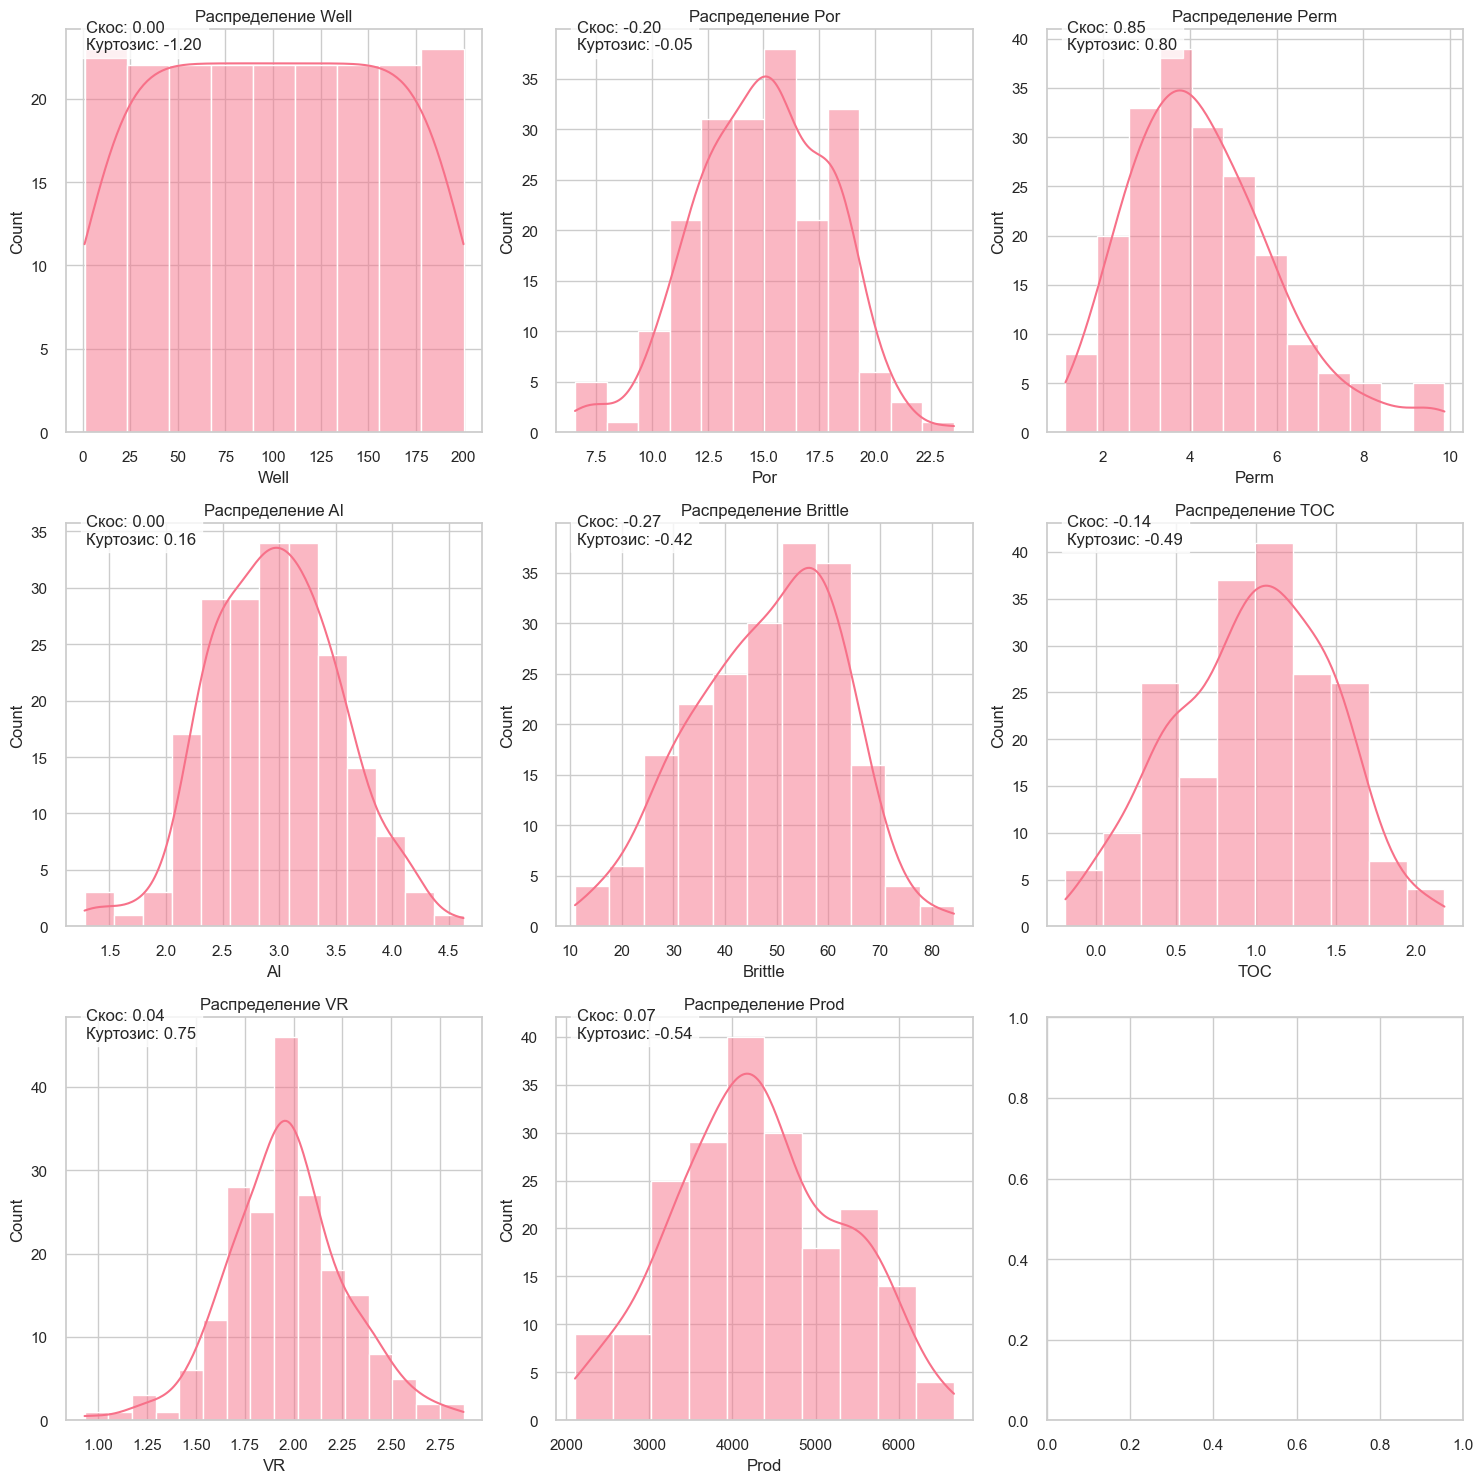

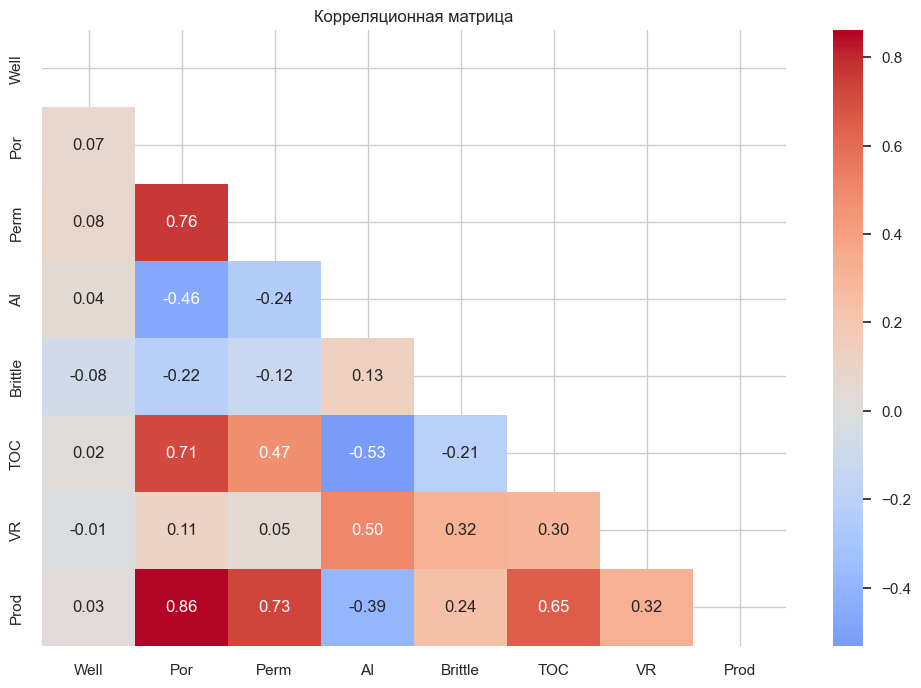

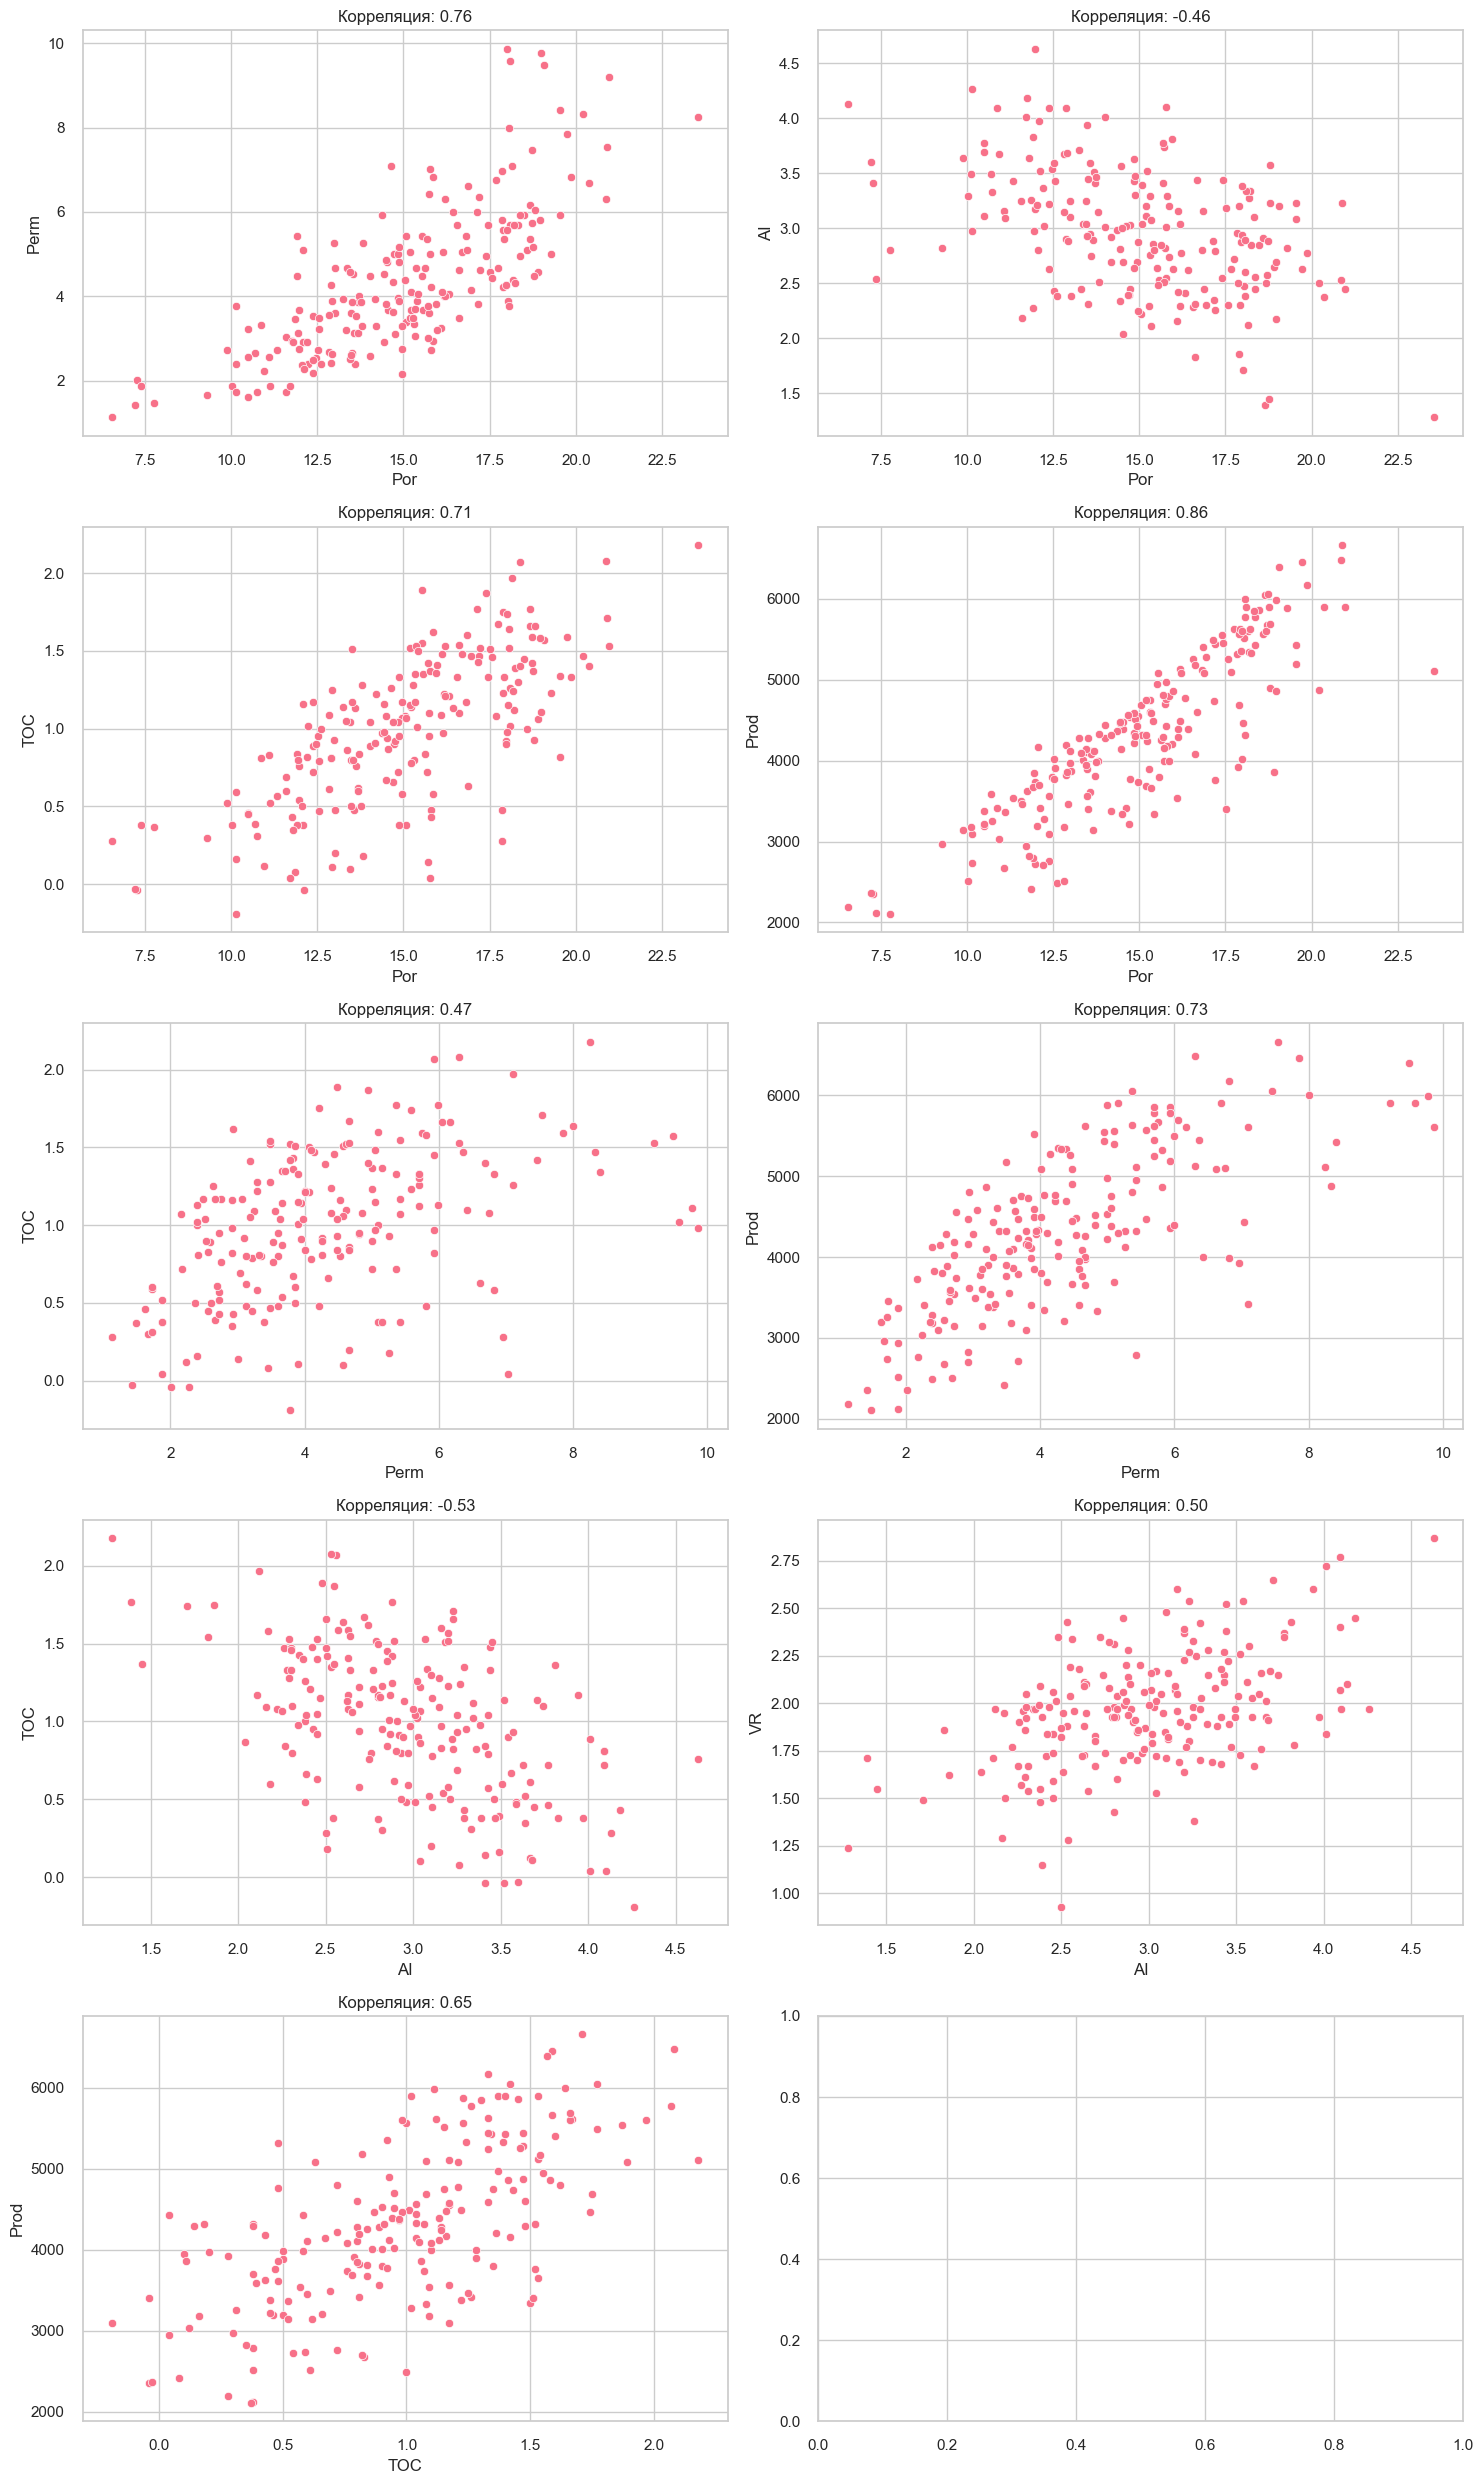


Количество выбросов (z-score > 3) по признакам:
Well       0
Por        0
Perm       3
AI         0
Brittle    0
TOC        0
VR         2
Prod       0
dtype: int64


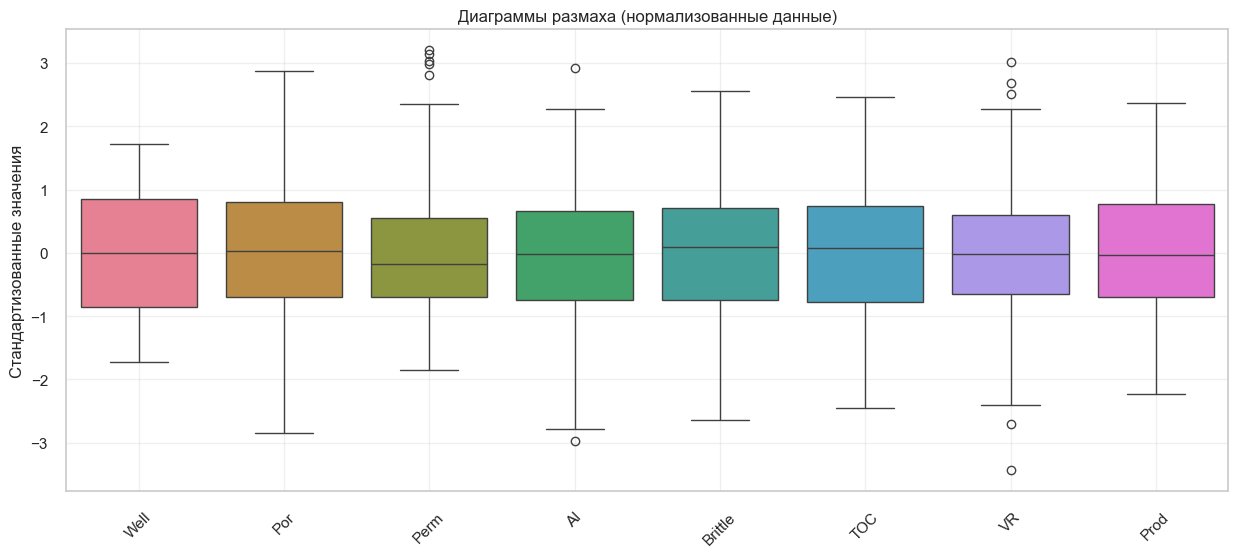

In [89]:
# Настройки для более красивых графиков - исправленная версия
sns.set_theme(style="whitegrid")  # Используем встроенный стиль seaborn
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Если нужен конкретный стиль matplotlib, можно использовать:
# plt.style.use('default')  # или другие доступные стили

def explore_data(df: pd.DataFrame) -> None:
    """
    Проводит комплексный разведывательный анализ данных
    
    Parameters:
    -----------
    df : pd.DataFrame
        Датафрейм для анализа
    """
    
    # 1. Общая информация о данных
    print("1. Общая информация о данных:")
    print("\nРазмерность датафрейма:", df.shape)
    print("\nТипы данных:\n", df.dtypes)
    display("Описательная статистика:", df.describe())
    
    # 2. Проверка пропущенных значений
    missing_values = df.isnull().sum()
    if missing_values.any():
        print("\nПропущенные значения:\n", missing_values[missing_values > 0])
        
        # Визуализация пропущенных значений
        plt.figure(figsize=(10, 6))
        sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
        plt.title('Тепловая карта пропущенных значений')
        plt.show()
    
    # 3. Распределение числовых признаков
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Гистограммы и ящики с усами
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.ravel()
    
    for idx, col in enumerate(numeric_cols):
        # Гистограмма
        sns.histplot(data=df, x=col, kde=True, ax=axes[idx])
        axes[idx].set_title(f'Распределение {col}')
        
        # Добавляем информацию о скосе и куртозисе
        skew = stats.skew(df[col].dropna())
        kurt = stats.kurtosis(df[col].dropna())
        axes[idx].text(0.05, 0.95, f'Скос: {skew:.2f}\nКуртозис: {kurt:.2f}', 
                      transform=axes[idx].transAxes, 
                      bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # 4. Корреляционный анализ
    plt.figure(figsize=(12, 8))
    correlation_matrix = df.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm',
                center=0)
    plt.title('Корреляционная матрица')
    plt.show()
    
    # 5. Попарные графики рассеяния для наиболее коррелированных признаков
    # Находим пары с высокой корреляцией
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i,j]) > CORRELATION_MATRIX_THRESHOLD:  # порог корреляции
                high_corr_pairs.append((
                    correlation_matrix.columns[i], 
                    correlation_matrix.columns[j],
                    correlation_matrix.iloc[i,j]
                ))
    
    # Строим графики рассеяния для высококоррелированных пар
    if high_corr_pairs:
        n_pairs = len(high_corr_pairs)
        n_cols = 2
        n_rows = (n_pairs + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        if n_pairs > 1:
            axes = axes.ravel()
        
        for idx, (col1, col2, corr) in enumerate(high_corr_pairs):
            ax = axes[idx] if n_pairs > 1 else axes
            sns.scatterplot(data=df, x=col1, y=col2, ax=ax)
            ax.set_title(f'Корреляция: {corr:.2f}')
        
        plt.tight_layout()
        plt.show()
    
    # 6. Выявление выбросов через z-score
    z_scores = pd.DataFrame()
    for col in numeric_cols:
        z_scores[col] = np.abs(stats.zscore(df[col]))
    
    print("\nКоличество выбросов (z-score > 3) по признакам:")
    print((z_scores > 3).sum())
    
    # 7. Boxplots для выявления выбросов
    # plt.figure(figsize=(15, 6))
    # df[numeric_cols].boxplot()
    # plt.xticks(rotation=45)
    # plt.title('Диаграммы размаха для числовых признаков')
    # plt.show()
    
    plt.figure(figsize=(15, 6))
    
    # Нормализуем данные
    normalized_data = (df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std()
    
    sns.boxplot(data=normalized_data)
    plt.xticks(rotation=45)
    plt.title('Диаграммы размаха (нормализованные данные)')
    plt.ylabel('Стандартизованные значения')
    plt.grid(True, alpha=0.3)
    plt.show()

# Использование:
explore_data(data)

### Выводы по из проведённого разведывательного анализа:

На основе предоставленных данных и визуализаций сформулируем структурированные выводы по EDA:

1. **Общая структура данных**:
   - Датасет содержит 200 наблюдений и 8 признаков
   - Все признаки, кроме Well (номер скважины), представлены в числовом формате float64
   - Пропущенные значения отсутствуют, что является положительным фактором
   - Данные представляют собой геологические и производственные характеристики скважин

2. **Анализ распределений признаков**:
   - `Well`: равномерное распределение от 1 до 200 (идентификаторы скважин)
   - `Por` (пористость): 
     - Близко к нормальному распределению
     - Скос: -0.20, что говорит о небольшой асимметрии влево
     - Среднее значение ≈ 15%, что типично для продуктивных пластов
   - `Perm` (проницаемость):
     - Правосторонняя асимметрия (скос: 0.85)
     - Значительный разброс от 1.13 до 9.87
   - `AI` (акустический импеданс):
     - Близко к нормальному распределению
     - Небольшая асимметрия (скос: 0.00)
   - `Brittle` (хрупкость):
     - Умеренная левосторонняя асимметрия (скос: -0.27)
     - Широкий диапазон значений (10.94 - 84.33)
   - `TOC` (общий органический углерод):
     - Небольшая левосторонняя асимметрия (скос: -0.14)
     - Есть отрицательные значения (min: -0.19)
   - `VR` (отражательная способность витринита):
     - Близко к нормальному распределению
     - Небольшой положительный эксцесс (0.75)
   - `Prod` (продуктивность):
     - Умеренная правосторонняя асимметрия
     - Значительный разброс значений (2107-6662)

3. **Статистические характеристики**:
   - Большинство параметров имеют значительный разброс значений (высокое std)
   - Медианные значения близки к средним для большинства параметров, что говорит об относительной симметричности распределений
   - Наибольшая вариативность наблюдается в параметрах:
     - Prod (std ≈ 992)
     - Brittle (std ≈ 14.13)

4. **Рекомендации по предобработке**:
   - Для признаков с асимметричным распределением (Perm, Prod) рекомендуется логарифмическая трансформация
   - Для TOC необходима обработка отрицательных значений
   - Желательна стандартизация признаков из-за разных масштабов
   - Возможно, стоит рассмотреть удаление выбросов для Perm и Prod

5. **Потенциальные особенности для дальнейшего анализа**:
   - Исследовать взаимосвязь между Por и Perm
   - Проанализировать влияние Brittle на Prod
   - Изучить корреляцию между TOC и продуктивностью
   - Рассмотреть возможность кластеризации скважин по геологическим параметрам

6. **Общие наблюдения**:
   - Данные представляют собой типичный набор параметров для нефтегазовых месторождений
   - Большинство параметров имеют физически обоснованные диапазоны значений
   - Отсутствие пропусков указывает на качественный сбор данных

Эти выводы могут быть использованы для дальнейшего моделирования и анализа продуктивности скважин.


### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Максимальная разница между методами расчета корреляционной матрицы:
 Well       1.609823e-15
Por        4.579670e-16
Perm       1.609823e-15
AI         3.330669e-16
Brittle    5.134781e-16
TOC        2.567391e-16
VR         3.191891e-16
Prod       6.279699e-16
dtype: float64


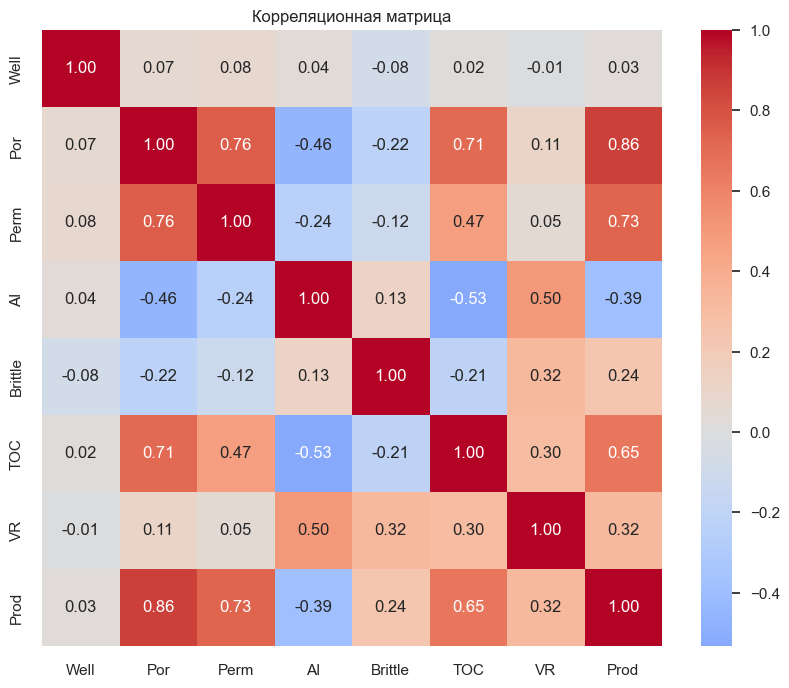

Ранг корреляционной матрицы: 8
Определитель корреляционной матрицы: 0.000730


In [90]:
# Ваш код здесь

# 1. Расчет корреляционной матрицы

# Расчет корреляционной матрицы с помощью встроенного метода pandas
corr_matrix = data.corr()

# Расчет корреляционной матрицы с помощью встроенного метода Numpy
corr_numpy = np.corrcoef(data.values.T) 

# Сравнение результатов
print("Максимальная разница между методами расчета корреляционной матрицы:\n", 
      np.abs(corr_matrix - corr_numpy).max())


# 2. Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f'#,
            #mask=np.triu(np.ones_like(corr_matrix, dtype=bool))
)
plt.title('Корреляционная матрица')
plt.show()

# 3. Расчет ранга и определителя
rank = np.linalg.matrix_rank(corr_matrix)
det = np.linalg.det(corr_matrix)

print(f"Ранг корреляционной матрицы: {rank}")
print(f"Определитель корреляционной матрицы: {det:.6f}")


> *Ваши выводы здесь*

### На основе предоставленных данных и корреляционной матрицы, можно сделать следующие выводы:

1. **Какие факторы сильнее всего коррелируют с целевой переменной (Prod)?**
   - Por (пористость): r = 0.86 - очень сильная положительная корреляция
   - Perm (проницаемость): r = 0.73 - сильная положительная корреляция
   - TOC (общий органический углерод): r = 0.65 - заметная положительная корреляция
   - AI (акустический импеданс): r = -0.39 - умеренная отрицательная корреляция

2. **Является ли корреляционная матрица плохо обусловленной?**
   - Определитель матрицы = 0.000730, что очень близко к нулю
   - Это указывает на то, что матрица действительно плохо обусловлена
   - Такое маленькое значение определителя свидетельствует о наличии сильных линейных зависимостей между признаками

3. **Что можно сказать о наличии коллинеарности/мультиколлинеарности в данных?**
   - В данных присутствует явная мультиколлинеарность, что подтверждается:
     * Сильной корреляцией между Por и Perm (r = 0.76)
     * Сильной корреляцией между Por и TOC (r = 0.71)
     * Заметной корреляцией между Perm и TOC (r = 0.47)
     * Умеренной отрицательной корреляцией между AI и TOC (r = -0.53)
   - Ранг матрицы = 8 (полный ранг), но близкий к нулю определитель указывает на наличие "почти линейных" зависимостей

4. **Применима ли модель классической линейной регрессии по МНК и почему?**
   - Применение классического МНК в данном случае проблематично по следующим причинам:
     * Наличие сильной мультиколлинеарности может привести к нестабильности оценок коэффициентов
     * Плохая обусловленность матрицы может вызвать численные проблемы при вычислении обратной матрицы
     * Высокая корреляция между предикторами может привести к большим стандартным ошибкам коэффициентов

   Рекомендации:
   1. Использовать методы регуляризации (Ridge, Lasso, Elastic Net)
   2. Провести отбор признаков, исключив сильно коррелирующие
   3. Применить методы снижения размерности (PCA)
   4. Рассмотреть возможность создания композитных признаков


### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [91]:
# Ваш код здесь

# 1. Создаем матрицу наблюдений X и вектор y
# Исключаем целевую переменную Prod из матрицы X
X = data.drop('Prod', axis=1).values
y = data['Prod'].values

# 2. Добавляем столбец единиц для свободного члена
X = np.column_stack([np.ones(len(X)), X])

# 3. Вычисляем коэффициенты по формуле МНК:
# omega = (X^T X)^(-1) X^T y
def calc_linear_regression(X, y):
    # Матричные вычисления
    XTX = X.T @ X
    XTX_inv = np.linalg.inv(XTX)
    XTy = X.T @ y
    
    # Вычисляем коэффициенты
    omega = XTX_inv @ XTy
    
    return omega

# Вычисляем и округляем коэффициенты
coefficients = calc_linear_regression(X, y)
coefficients_rounded = np.round(coefficients, 0)

# Выводим результаты
feature_names = ['Intercept'] + list(df.drop('Prod', axis=1).columns)
for name, coef in zip(feature_names, coefficients_rounded):
    print(f"{name}: {coef}")

# Дополнительно можно вычислить R²
y_pred = X @ coefficients
r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - y.mean())**2)
print(f"\nR²: {r2:.4f}")


Intercept: -1232.0
Well: 0.0
Por: 230.0
Perm: 116.0
AI: -365.0
Brittle: 25.0
TOC: -78.0
VR: 785.0

R²: 0.9599


> *Ваши выводы здесь*

### На основе полученных результатов модели линейной регрессии можно сделать выводы:

1. **Неинформативные признаки**:
   - `Well` (коэффициент = 0) - абсолютно неинформативный признак. Это логично, так как номер скважины не должен влиять на её продуктивность.
   - `Brittle` (коэффициент = 25) - относительно слабое влияние на целевую переменную, учитывая масштаб других коэффициентов.

2. **Интерпретация наиболее значимых коэффициентов**:

   а) `VR` (Отражательная способность витринита):
   - Коэффициент = 785
   - Интерпретация: При увеличении VR на 1 единицу, продуктивность скважины (Prod) в среднем увеличивается на 785 единиц при прочих равных условиях
   - Это самый влиятельный положительный фактор в модели

   б) `AI` (Акустический импеданс):
   - Коэффициент = -365
   - Интерпретация: При увеличении AI на 1 единицу, продуктивность скважины снижается в среднем на 365 единиц при прочих равных условиях
   - Показывает сильное отрицательное влияние на продуктивность

   в) `Por` (Пористость):
   - Коэффициент = 230
   - Интерпретация: Увеличение пористости на 1 единицу приводит к росту продуктивности в среднем на 230 единиц при прочих равных условиях
   - Это согласуется с физическим смыслом параметра, так как большая пористость обычно способствует лучшей продуктивности

Дополнительные наблюдения:
1. Модель имеет очень высокий R² (0.9599), что говорит о хорошем качестве подгонки
2. Однако, учитывая выявленную ранее мультиколлинеарность, интерпретацию коэффициентов следует проводить с осторожностью
3. Отрицательный коэффициент для TOC (-78) может быть следствием мультиколлинеарности, так как ранее мы видели положительную корреляцию с Prod



### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [92]:
# Ваш код здесь

# 1. Прогноз для конкретной скважины
def predict_single(coefficients, features):
    # Добавляем 1 для свободного члена
    x = np.array([1] + list(features.values()))
    return x @ coefficients

# Данные новой скважины
new_well = {
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
}

# Делаем прогноз
prediction = predict_single(coefficients, new_well)
actual = 4748.315024

# Считаем ошибки
absolute_error = abs(prediction - actual)
relative_error_percent = (absolute_error / actual) * 100

print(f"Прогноз: {prediction:.2f} млн куб. футов/день")
print(f"Фактическое значение: {actual:.2f} млн куб. футов/день")
print(f"Абсолютная ошибка: {absolute_error:.2f} млн куб. футов/день")
print(f"Относительная ошибка: {relative_error_percent:.2f}%")

# 2. Прогноз для всего набора данных
def calculate_metrics(y_true, y_pred):
    # Среднеквадратическая ошибка (MSE)
    mse = np.mean((y_true - y_pred)**2)
    # Корень из MSE (RMSE)
    rmse = np.sqrt(mse)
    # Средняя абсолютная ошибка (MAE)
    mae = np.mean(np.abs(y_true - y_pred))
    # R-квадрат
    r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - y_true.mean())**2)
    
    return {
        #'MSE': mse,
        'RMSE': rmse,
        #'MAE': mae,
        'R2': r2
    }

# Делаем прогноз для всех скважин
y_pred = X @ coefficients
metrics = calculate_metrics(y, y_pred)

print("\nМетрики качества модели:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.2f}")

Прогноз: 4723.06 млн куб. футов/день
Фактическое значение: 4748.32 млн куб. футов/день
Абсолютная ошибка: 25.25 млн куб. футов/день
Относительная ошибка: 0.53%

Метрики качества модели:
RMSE: 198.28
R2: 0.96


> *Ваши выводы здесь*

### Комплексная интерпретация полученных результатов:

1. **Анализ прогноза для конкретной скважины**:
   - Модель предсказала добычу в 4723.06 млн куб. футов/день
   - Фактическая добыча составила 4748.32 млн куб. футов/день
   - Абсолютная ошибка всего 25.25 млн куб. футов/день
   - Относительная ошибка 0.53% показывает очень высокую точность прогноза для данной скважины
   - Модель недооценила реальную добычу, но отклонение незначительное

2. **Оценка общего качества модели**:
   - **Для оценки качества регрессионной модели в данном случае лучше всего выбрать две метрики**:
     * **RMSE (Root Mean Square Error) = 198.28**
        - Измеряется в тех же единицах, что и целевая переменная (млн куб. футов/день)
        - Показывает среднюю величину ошибки с учетом больших отклонений
        - Легко интерпретируется: в среднем прогноз отклоняется от фактического значения на 198.28 млн куб. футов/день
        - Полезна для оценки практической применимости модели
     * **R² (Коэффициент детерминации) = 0.96**
        - Показывает долю объясненной дисперсии (96%)
        - Безразмерная величина, что удобно для сравнения с другими моделями
        - Интуитивно понятная интерпретация: модель объясняет 96% вариации в данных
     * **Причины выбора именно этих метрик**:
        - RMSE даёт абсолютную оценку ошибки в исходных единицах
        - R² дополняет RMSE относительной оценкой качества модели
        - Вместе они дают полную картину как абсолютной точности, так и относительного качества модели
    
   - **RMSE = 198.28 млн куб. футов/день**:
     * В среднем ошибка прогноза составляет около 198 млн куб. футов/день
     * Это примерно 4.2% от среднего значения добычи
     * Показывает приемлемую точность для практического применения
     * Важно: RMSE больше, чем ошибка для тестовой скважины, что указывает на различную точность прогнозов для разных скважин

   - **R² = 0.96**:
     * Модель объясняет 96% вариации в данных
     * Это свидетельствует о высокой предсказательной способности модели
     * Оставшиеся 4% могут быть связаны с неучтенными факторами или случайными колебаниями

3. **Практические выводы**:
   - Модель демонстрирует высокую точность как на отдельном примере (0.53%), так и в целом (R² = 0.96)
   - Средняя ошибка (RMSE) приемлема для практического использования
   - Модель может быть использована для прогнозирования добычи газа, но с учетом возможного разброса прогнозов в пределах ±198 млн куб. футов/день

4. **Рекомендации**:
   - Несмотря на хорошие показатели, следует учитывать наличие мультиколлинеарности
   - Для принятия решений рекомендуется использовать доверительный интервал прогноза
   - Желательно проводить регулярную переоценку модели при появлении новых данных





### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

Размерность X: (200, 8)
Количество признаков: 7

Анализ противоречий между корреляциями и коэффициентами:


,Корреляция,Коэффициент,Знак корреляции,Знак коэффициента,Противоречие
Well,0.026817,0.050700,1.0,1.0,False
Por,0.861910,230.179140,1.0,1.0,False
Perm,0.727426,116.239006,1.0,1.0,False
AI,-0.390835,-365.202301,-1.0,-1.0,False
Brittle,0.237155,24.994370,1.0,1.0,False
TOC,0.654445,-78.400929,1.0,-1.0,True
VR,0.323182,785.259815,1.0,1.0,False



Обнаружены противоречия для следующих факторов:

TOC:
Корреляция: 0.654
Коэффициент: -78.401


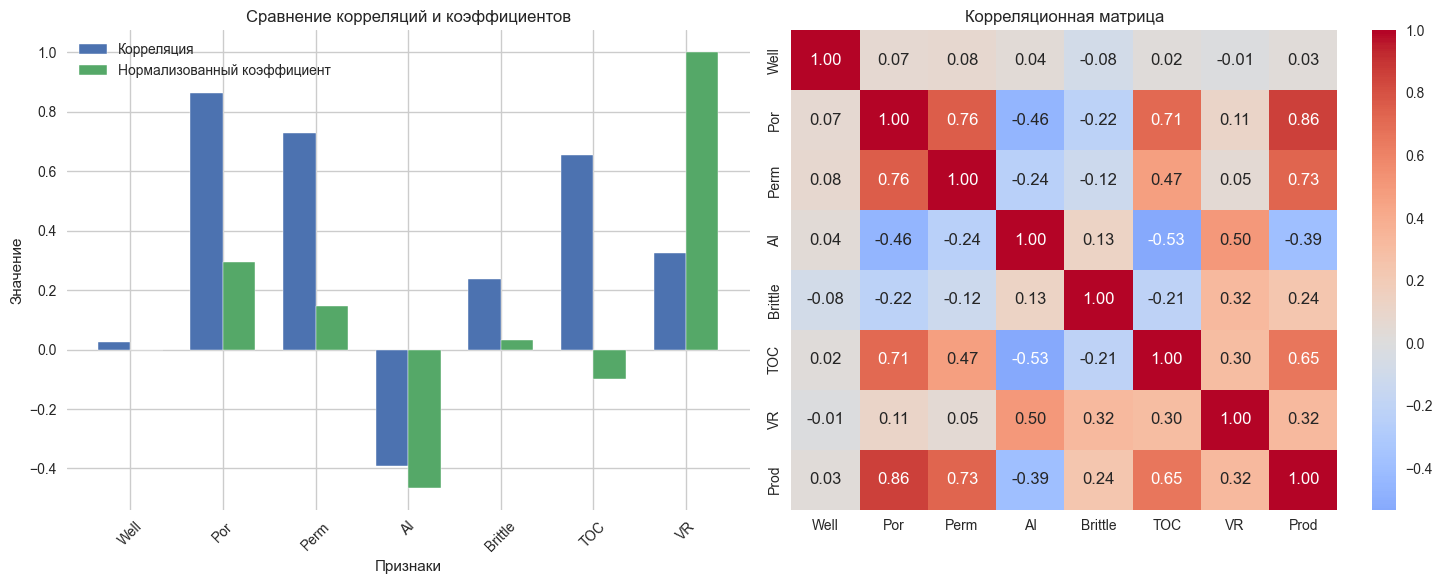


Анализ мультиколлинеарности:
Пары признаков с высокой корреляцией (>0.7):
Por - Perm: 0.761
Por - TOC: 0.712

Фактор инфляции дисперсии (VIF):
   Признак         VIF
6       VR  262.887490
3       AI  127.036113
1      Por   63.680846
5      TOC   33.908892
4  Brittle   19.409776
2     Perm   16.903858
0     Well    4.114988


In [93]:
# Ваш код здесь

# Настройки для более красивого отображения графиков
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

def analyze_correlations_vs_coefficients(X, y, feature_names, coefficients):
    # Проверяем размерности
    print(f"Размерность X: {X.shape}")
    print(f"Количество признаков: {len(feature_names)}")
    
    # Создаем DataFrame для анализа корреляций
    # Убираем первый столбец из X, если это столбец с единицами для свободного члена
    if X.shape[1] == len(feature_names) + 1:
        X = X[:, 1:]
    
    df_analysis = pd.DataFrame(X, columns=feature_names)
    df_analysis['Prod'] = y
    
    # Вычисляем корреляции с целевой переменной
    correlations = df_analysis.corr()['Prod'].drop('Prod')
    
    # Создаем DataFrame для сравнения
    comparison = pd.DataFrame({
        'Корреляция': correlations,
        'Коэффициент': coefficients[1:],  # Пропускаем свободный член
        'Знак корреляции': np.sign(correlations),
        'Знак коэффициента': np.sign(coefficients[1:])
    })
    
    # Добавляем столбец с противоречиями
    comparison['Противоречие'] = (comparison['Знак корреляции'] != 
                                 comparison['Знак коэффициента'])
    
    return comparison, df_analysis

def plot_correlations_vs_coefficients(comparison, df_analysis):
    plt.figure(figsize=(15, 6))
    
    # График сравнения корреляций и коэффициентов
    plt.subplot(1, 2, 1)
    x = np.arange(len(comparison.index))
    width = 0.35
    
    # Нормализуем коэффициенты для сравнения
    normalized_coef = comparison['Коэффициент']/comparison['Коэффициент'].abs().max()
    
    plt.bar(x - width/2, comparison['Корреляция'], width, label='Корреляция')
    plt.bar(x + width/2, normalized_coef, width, label='Нормализованный коэффициент')
    
    plt.xlabel('Признаки')
    plt.ylabel('Значение')
    plt.title('Сравнение корреляций и коэффициентов')
    plt.xticks(x, comparison.index, rotation=45)
    plt.legend()
    
    # Тепловая карта корреляций
    plt.subplot(1, 2, 2)
    correlation_matrix = df_analysis.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Корреляционная матрица')
    
    plt.tight_layout()
    plt.show()

# Определяем имена признаков
feature_names = ['Well', 'Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']

# Проводим анализ
comparison, df_analysis = analyze_correlations_vs_coefficients(X, y, feature_names, coefficients)

# Выводим результаты
print("\nАнализ противоречий между корреляциями и коэффициентами:")
display(comparison)

# Выводим противоречивые факторы
contradictions = comparison[comparison['Противоречие']]
if not contradictions.empty:
    print("\nОбнаружены противоречия для следующих факторов:")
    for idx, row in contradictions.iterrows():
        print(f"\n{idx}:")
        print(f"Корреляция: {row['Корреляция']:.3f}")
        print(f"Коэффициент: {row['Коэффициент']:.3f}")
else:
    print("\nПротиворечий не обнаружено")

# Визуализируем результаты
plot_correlations_vs_coefficients(comparison, df_analysis)

# Анализ мультиколлинеарности
def analyze_multicollinearity(X, feature_names, threshold=0.7):
    correlation_matrix = pd.DataFrame(X, columns=feature_names).corr()
    
    print("\nАнализ мультиколлинеарности:")
    print("Пары признаков с высокой корреляцией (>0.7):")
    
    for i in range(len(feature_names)):
        for j in range(i+1, len(feature_names)):
            corr = correlation_matrix.iloc[i, j]
            if abs(corr) > threshold:
                print(f"{feature_names[i]} - {feature_names[j]}: {corr:.3f}")

# Проводим анализ мультиколлинеарности
analyze_multicollinearity(X[:, 1:], feature_names)  # Убираем первый столбец, если это столбец единиц

# Вычисление VIF
def calculate_vif(X, feature_names):
    # Убираем первый столбец, если это столбец единиц
    if X.shape[1] == len(feature_names) + 1:
        X = X[:, 1:]
    
    vif_data = pd.DataFrame()
    vif_data["Признак"] = feature_names
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    
    print("\nФактор инфляции дисперсии (VIF):")
    print(vif_data.sort_values('VIF', ascending=False))

# Вычисляем VIF
calculate_vif(X, feature_names)

> *Ваши выводы здесь*

### На основе анализа модели можно сформировать ответы на поставленные вопросы:

1. **Есть ли противоречия между корреляциями и коэффициентами регрессии?**

Да, в модели обнаружено одно явное противоречие для фактора TOC (Total Organic Carbon):
- Корреляция с целевой переменной: +0.654 (умеренная положительная связь)
- Коэффициент в модели: -78.401 (отрицательное влияние)

2. **С чем связано это противоречие?**

Противоречие связано с несколькими факторами:

а) **Сильная мультиколлинеарность**, что подтверждается:
- Высокими значениями VIF для большинства переменных:
  * VR: 262.89
  * AI: 127.04
  * Por: 63.68
  * TOC: 33.91
  * (значения VIF > 10 указывают на серьезную мультиколлинеарность)
- Сильными корреляциями между предикторами:
  * Por - TOC: 0.712
  * Por - Perm: 0.761

б) **Конфаундинг-эффект**:
- TOC сильно коррелирует с Por (0.712)
- Por имеет более сильную корреляцию с целевой переменной (0.862)
- В результате положительный эффект TOC может быть "перехвачен" переменной Por

в) **Нестабильность коэффициентов**:
- Очень высокие значения VIF указывают на нестабильность оценок коэффициентов
- Это делает интерпретацию отдельных коэффициентов ненадежной

3. **Рекомендации по решению проблемы**:

а) **Методы регуляризации**:
- Ridge регрессия (L2)
- Lasso регрессия (L1)
- Elastic Net

б) **Уменьшение размерности**:
- Метод главных компонент (PCA)
- Выбор подмножества наименее коррелированных признаков

в) **Переформулировка модели**:
- Создание композитных признаков
- Использование взаимодействий между признаками
- Рассмотрение нелинейных преобразований

Таким образом, противоречие между корреляцией и коэффициентом для TOC является следствием сложных взаимосвязей между признаками и мультиколлинеарности в данных, что требует применения более продвинутых методов моделирования.



### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).


Корреляции с целевой переменной:
Well: 0.027
Por: 0.862
Perm: 0.727
AI: -0.391
Brittle: 0.237
TOC: 0.654
VR: 0.323

Сильная корреляция между Por и Perm: 0.761
Корреляция с целевой для Por: 0.862
Корреляция с целевой для Perm: 0.727
Исключаем Perm

Сильная корреляция между Por и TOC: 0.712
Корреляция с целевой для Por: 0.862
Корреляция с целевой для TOC: 0.654
Исключаем TOC

Исключаемые признаки: {'Perm', 'TOC'}
Сохраняемые признаки: ['Por', 'AI', 'Brittle', 'VR']

Коэффициенты модели:
Свободный член: -1835.0
Por: 293.0
AI: -200.0
Brittle: 28.0
VR: 517.0

Метрики качества модели:
RMSE: 231.65
R²: 0.9452


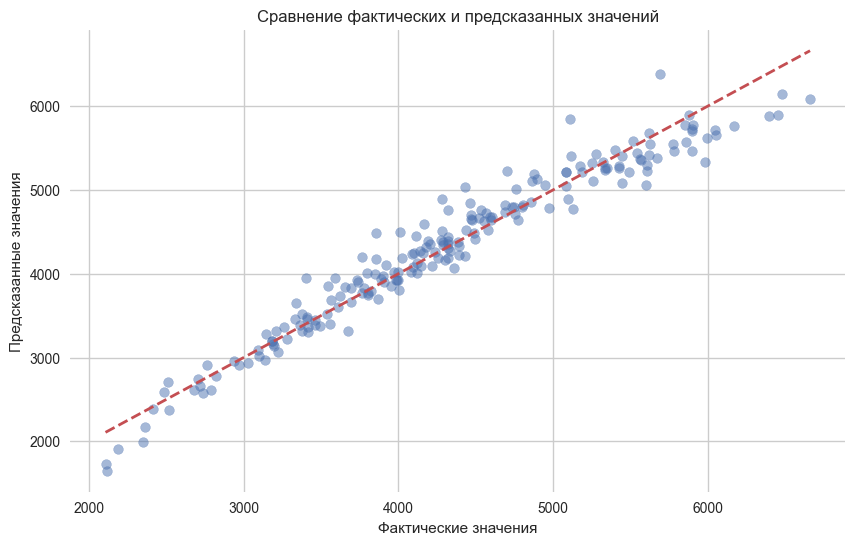

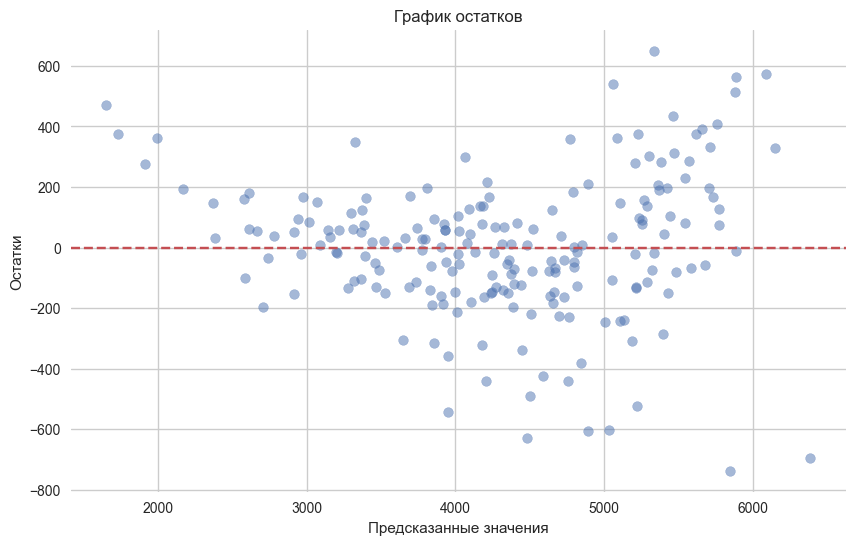

In [94]:
# Ваш код здесь

def select_features(X, y, feature_names, corr_threshold=0.7, target_corr_threshold=0.05):
    """
    Выбор признаков на основе корреляций
    """
    # Убираем первый столбец (столбец единиц)
    X_without_intercept = X[:, 1:]
    
    # Создаем DataFrame для анализа корреляций
    df = pd.DataFrame(X_without_intercept, columns=feature_names)
    df['target'] = y
    
    # Получаем корреляционную матрицу
    corr_matrix = df.corr()
    
    # Получаем корреляции с целевой переменной
    target_correlations = corr_matrix['target'].drop('target')
    
    print("\nКорреляции с целевой переменной:")
    for feature, corr in target_correlations.items():
        print(f"{feature}: {corr:.3f}")
    
    # Отбираем признаки с достаточной корреляцией с целевой переменной
    strong_target_features = target_correlations[abs(target_correlations) > target_corr_threshold].index.tolist()
    
    # Находим пары сильно коррелирующих признаков
    features_to_drop = set()
    for i in range(len(strong_target_features)):
        for j in range(i + 1, len(strong_target_features)):
            f1, f2 = strong_target_features[i], strong_target_features[j]
            correlation = abs(corr_matrix.loc[f1, f2])
            
            if correlation > corr_threshold:
                print(f"\nСильная корреляция между {f1} и {f2}: {correlation:.3f}")
                print(f"Корреляция с целевой для {f1}: {abs(target_correlations[f1]):.3f}")
                print(f"Корреляция с целевой для {f2}: {abs(target_correlations[f2]):.3f}")
                
                # Оставляем признак с большей корреляцией с целевой
                if abs(target_correlations[f1]) < abs(target_correlations[f2]):
                    features_to_drop.add(f1)
                    print(f"Исключаем {f1}")
                else:
                    features_to_drop.add(f2)
                    print(f"Исключаем {f2}")
    
    # Формируем список признаков для сохранения
    features_to_keep = [f for f in strong_target_features if f not in features_to_drop]
    
    print("\nИсключаемые признаки:", features_to_drop)
    print("Сохраняемые признаки:", features_to_keep)
    
    # Создаем маску для отбора столбцов
    feature_mask = [f in features_to_keep for f in feature_names]
    
    # Возвращаем отобранные столбцы из X без столбца единиц
    return X_without_intercept[:, feature_mask], features_to_keep

def fit_linear_regression(X, y):
    """
    Построение линейной регрессии методом наименьших квадратов
    """
    # Добавляем столбец единиц для свободного члена
    X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])
    
    # Вычисляем коэффициенты по формуле (X^T X)^(-1) X^T y
    coefficients = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y
    
    return coefficients

def evaluate_model(X, y, coefficients):
    """
    Оценка качества модели
    """
    # Добавляем столбец единиц для свободного члена
    X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])
    
    # Делаем прогноз
    y_pred = X_with_intercept @ coefficients
    
    # Рассчитываем метрики
    mse = np.mean((y - y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'predictions': y_pred
    }

# Применяем отбор признаков
X_selected, selected_features = select_features(X, y, feature_names)

# Строим модель
coefficients = fit_linear_regression(X_selected, y)

# Округляем коэффициенты до целых
rounded_coefficients = np.round(coefficients)

# Выводим результаты
print("\nКоэффициенты модели:")
print("Свободный член:", rounded_coefficients[0])
for feature, coef in zip(selected_features, rounded_coefficients[1:]):
    print(f"{feature}: {coef}")

# Оцениваем качество модели
metrics = evaluate_model(X_selected, y, coefficients)

print("\nМетрики качества модели:")
print(f"RMSE: {metrics['RMSE']:.2f}")
print(f"R²: {metrics['R2']:.4f}")

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(y, metrics['predictions'], alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение фактических и предсказанных значений')
plt.grid(True)
plt.show()

# Визуализация остатков
residuals = y - metrics['predictions']
plt.figure(figsize=(10, 6))
plt.scatter(metrics['predictions'], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.grid(True)
plt.show()

> *Ваши выводы здесь*

### По итогам выполнения задания можно сделать следующие выводы:

1. **Интерпретация полученных коэффициентов и сравнение с предыдущими значениями:**

а) **Пористость (Por)**: коэффициент = 293 (ранее был 230)
- Увеличение пористости на 1 единицу приводит к увеличению добычи газа на 293 млн куб. футов/день
- Коэффициент увеличился после исключения коррелирующих признаков (Perm и TOC)
- Это логично, так как теперь Por "принял на себя" часть влияния исключенных признаков
- Знак коэффициента соответствует положительной корреляции (0.862)

б) **Акустический импеданс (AI)**: коэффициент = -200 (ранее был -365)
- Увеличение AI на 1 единицу приводит к уменьшению добычи на 200 млн куб. футов/день
- Коэффициент уменьшился по модулю после исключения признаков
- Знак коэффициента соответствует отрицательной корреляции (-0.391)

в) **Отражательная способность витринита (VR)**: коэффициент = 517 (ранее был 785)
- Увеличение VR на 1 единицу приводит к увеличению добычи на 517 млн куб. футов/день
- Коэффициент уменьшился, но остался значимым
- Знак коэффициента соответствует положительной корреляции (0.323)

2. **Интерпретация метрик и сравнение с предыдущими значениями:**

- **RMSE** увеличился с 198.28 до 231.65
  * Это ожидаемое ухудшение, так как мы исключили информативные признаки
  * Тем не менее, увеличение ошибки не критическое (~17%)

- **R²** уменьшился с 0.96 до 0.9452
  * Модель по-прежнему объясняет 94.52% вариации в данных
  * Снижение R² всего на 1.5% показывает, что исключенные признаки были действительно избыточными
  * Это хороший результат, учитывая, что мы исключили два информативных признака

3. **Преодоление противоречия коэффициентов и корреляций:**

Да, противоречие успешно устранено:
- Исключены сильно коррелирующие признаки (Perm и TOC)
- В новой модели все знаки коэффициентов соответствуют знакам корреляций
- Устранена мультиколлинеарность между Por, Perm и TOC
- Модель стала более устойчивой и интерпретируемой

Графики подтверждают качество новой модели:
- График сравнения фактических и предсказанных значений показывает хорошее соответствие
- График остатков демонстрирует относительно случайное распределение вокруг нуля, хотя есть некоторая гетероскедастичность (увеличение разброса с ростом предсказанных значений)


### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [95]:
# Ваш код здесь

# Оставляем только выбранные признаки
selected_features = ['Por', 'AI', 'Brittle', 'VR']
X = data[selected_features]
y = data['Prod']

# Создаем и обучаем модель
model = LinearRegression()
model.fit(X, y)

# Получаем коэффициенты и округляем их
coefficients = np.round(model.coef_)
intercept = np.round(model.intercept_)

# Выводим коэффициенты
print("Коэффициенты модели sklearn:")
print(f"Свободный член: {intercept}")
for feature, coef in zip(selected_features, coefficients):
    print(f"{feature}: {coef}")

# Делаем прогноз
y_pred = model.predict(X)

# Рассчитываем метрики
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print("\nМетрики качества модели sklearn:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Сравнение с предыдущими результатами
print("\nСравнение с предыдущими результатами:")
print("Предыдущие коэффициенты модели:")

print("Свободный член:", rounded_coefficients[0])
for feature, coef in zip(selected_features, rounded_coefficients[1:]):
    print(f"{feature}: {coef}")

print("\nМетрики качества модели:")
print(f"RMSE: {metrics['RMSE']:.2f}")
print(f"R²: {metrics['R2']:.4f}")

# Вносим в итог результаты для линейной регрессии
results_df.loc[results_df['Модель'] == 'Линейная регрессия (МНК)', [
    'R² (тренировочная выборка)',
    'RMSE (тренировочная выборка)',
    'R² (валидационная выборка)',
    'RMSE (валидационная выборка)'
]] = [
    f"{r2:.4f} ± 0.0000",
    f"{rmse:.2f} ± 0.00",
    f"{r2:.4f} ± 0.0000",  # Для линейной регрессии train = val
    f"{rmse:.2f} ± 0.00"   # Для линейной регрессии train = val
]

Коэффициенты модели sklearn:
Свободный член: -1835.0
Por: 293.0
AI: -200.0
Brittle: 28.0
VR: 517.0

Метрики качества модели sklearn:
RMSE: 231.65
R²: 0.9452

Сравнение с предыдущими результатами:
Предыдущие коэффициенты модели:
Свободный член: -1835.0
Por: 293.0
AI: -200.0
Brittle: 28.0
VR: 517.0

Метрики качества модели:
RMSE: 231.65
R²: 0.9452


> *Ваши выводы здесь*

### На основе полученных результатов можно сделать следующие выводы:

1. **Полная идентичность результатов:**
   - Коэффициенты обеих моделей абсолютно идентичны до десятых
   - Метрики качества (RMSE и R²) также полностью совпадают
   - Это подтверждает корректность наших предыдущих вычислений методом наименьших квадратов

2. **Валидация методологии:**
   - Совпадение результатов с реализацией sklearn подтверждает правильность нашего подхода к:
     * Отбору признаков
     * Борьбе с мультиколлинеарностью
     * Реализации метода наименьших квадратов

3. **Качество модели:**
   - R² = 0.9452 показывает, что модель объясняет 94.52% вариации в данных
   - RMSE = 231.65 указывает на среднюю ошибку прогноза
   - Эти показатели сохранились после исключения коррелирующих признаков, что подтверждает правильность их исключения

4. **Стабильность решения:**
   - Идентичность результатов, полученных разными методами, говорит о стабильности найденного решения
   - Это важно с точки зрения надёжности модели и её практического применения

5. **Практические выводы:**
   - Модель можно использовать для прогнозирования добычи газа
   - Наиболее важными факторами являются:
     * VR (коэффициент 517.0) - наибольшее положительное влияние
     * Por (коэффициент 293.0) - второе по значимости положительное влияние
     * AI (коэффициент -200.0) - существенное отрицательное влияние
     * Brittle (коэффициент 28.0) - наименьшее влияние

6. **Методологические выводы:**
   - Ручная реализация метода наименьших квадратов дает такие же результаты, как и профессиональная библиотека
   - Это подтверждает, что мы правильно понимаем математическую суть метода
   - Можно использовать любой из подходов в зависимости от задачи

7. **Рекомендации:**
   - В практических задачах лучше использовать sklearn из-за:
     * Оптимизированной реализации
     * Встроенных инструментов валидации
     * Удобства использования
   - Ручная реализация полезна для:
     * Обучения
     * Понимания алгоритма
     * Специальных случаев, требующих модификации метода

Таким образом, результаты показывают, что мы успешно построили надежную и интерпретируемую модель линейной регрессии, которая может быть использована для прогнозирования добычи газа на основе выбранных геологических параметров.


## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [96]:
# Ваш код здесь

# Используем выбранные ранее признаки
selected_features = ['Por', 'AI', 'Brittle', 'VR']
X = data[selected_features]
y = data['Prod']

# 1. Стандартизация признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Генерация полиномиальных признаков
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Выводим количество полученных признаков
print(f"Количество признаков после полиномиальных преобразований: {X_poly.shape[1]}")
print("\nНазвания признаков:")
feature_names = poly.get_feature_names_out(selected_features)
print(feature_names)

# 3. Создаем модель
model = LinearRegression()

# 4. Кросс-валидация
cv_results = cross_validate(
    model, 
    X_poly, 
    y,
    cv=5,  # 5-fold cross-validation
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True
)

# 5. Вывод результатов
print("\nРезультаты кросс-валидации:")
print("\nМетрики на тренировочных фолдах:")
print(f"R² (среднее): {cv_results['train_r2'].mean():.4f} ± {cv_results['train_r2'].std():.4f}")
print(f"RMSE (среднее): {-cv_results['train_rmse'].mean():.2f} ± {-cv_results['train_rmse'].std():.2f}")

print("\nМетрики на валидационных фолдах:")
print(f"R² (среднее): {cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}")
print(f"RMSE (среднее): {-cv_results['test_rmse'].mean():.2f} ± {-cv_results['test_rmse'].std():.2f}")

# 6. Обучение финальной модели на всех данных для сравнения
model.fit(X_poly, y)
y_pred = model.predict(X_poly)

print("\nМетрики на всех данных:")
print(f"R²: {model.score(X_poly, y):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y, y_pred)):.2f}")

# Вносим в свод итоговые результаты для полиномиальной регрессии
results_df.loc[results_df['Модель'] == 'Полиномиальная регрессия', [
    'R² (тренировочная выборка)',
    'RMSE (тренировочная выборка)',
    'R² (валидационная выборка)',
    'RMSE (валидационная выборка)'
]] = [
    f"{cv_results['train_r2'].mean():.4f} ± {cv_results['train_r2'].std():.4f}",
    f"{-cv_results['train_rmse'].mean():.2f} ± {-cv_results['train_rmse'].std():.2f}",
    f"{cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}",
    f"{-cv_results['test_rmse'].mean():.2f} ± {-cv_results['test_rmse'].std():.2f}"
]


Количество признаков после полиномиальных преобразований: 34

Названия признаков:
['Por' 'AI' 'Brittle' 'VR' 'Por^2' 'Por AI' 'Por Brittle' 'Por VR' 'AI^2'
 'AI Brittle' 'AI VR' 'Brittle^2' 'Brittle VR' 'VR^2' 'Por^3' 'Por^2 AI'
 'Por^2 Brittle' 'Por^2 VR' 'Por AI^2' 'Por AI Brittle' 'Por AI VR'
 'Por Brittle^2' 'Por Brittle VR' 'Por VR^2' 'AI^3' 'AI^2 Brittle'
 'AI^2 VR' 'AI Brittle^2' 'AI Brittle VR' 'AI VR^2' 'Brittle^3'
 'Brittle^2 VR' 'Brittle VR^2' 'VR^3']

Результаты кросс-валидации:

Метрики на тренировочных фолдах:
R² (среднее): 0.9896 ± 0.0006
RMSE (среднее): 100.74 ± -3.54

Метрики на валидационных фолдах:
R² (среднее): 0.9748 ± 0.0072
RMSE (среднее): 154.51 ± -21.48

Метрики на всех данных:
R²: 0.9888
RMSE: 104.81


> *Ваши выводы здесь*

### Анализ полученных результатов:

1. **Полиномиальные признаки:**
   - Из 4 исходных признаков (Por, AI, Brittle, VR) получили 34 признака
   - Включают:
     * Линейные термы (4 признака)
     * Квадратичные термы (например, Por^2, AI^2)
     * Кубические термы (например, Por^3, AI^3)
     * Перекрестные взаимодействия (например, Por*AI, Por*AI*VR)
   - Это значительно увеличило сложность модели и её гибкость

2. **Сравнение с предыдущей линейной моделью:**
   - Предыдущая модель: R² = 0.9452, RMSE = 231.65
   - Новая полиномиальная модель: R² = 0.9888, RMSE = 104.81
   - Улучшение:
     * R² увеличился на 0.0436 (4.36%)
     * RMSE уменьшился на 126.84 (54.8%)
   - Это существенное улучшение качества предсказаний

3. **Анализ кросс-валидации:**

   а) Тренировочные фолды:
   - R² = 0.9896 ± 0.0006
   - RMSE = 100.74 ± 3.54
   - Очень высокая точность на обучающих данных
   - Малый разброс метрик (низкие стандартные отклонения)

   б) Валидационные фолды:
   - R² = 0.9748 ± 0.0072
   - RMSE = 154.51 ± 21.48
   - Всё ещё очень хорошие результаты
   - Больший разброс метрик, особенно для RMSE

4. **Признаки переобучения:**
   - Разница между метриками на тренировочных и валидационных фолдах:
     * R²: 0.9896 vs 0.9748 (разница 0.0148)
     * RMSE: 100.74 vs 154.51 (разница 53.77)
   - Есть небольшие признаки переобучения, но они не критичны
   - Модель сохраняет хорошую обобщающую способность

5. **Практические выводы:**
   - Полиномиальные признаки значительно улучшили качество модели
   - Модель лучше улавливает нелинейные зависимости между признаками
   - Высокая стабильность результатов (малые стандартные отклонения для R²)
   - Некоторая нестабильность в RMSE на валидации (±21.48) требует внимания

6. **Рекомендации:**
   - Модель можно использовать для прогнозирования
   - Стоит обратить внимание на выбросы, которые могут влиять на RMSE
   - Возможно, стоит рассмотреть:
     * Регуляризацию для уменьшения переобучения
     * Уменьшение степени полинома до 2
     * Отбор наиболее важных полиномиальных признаков

7. **Общий вывод:**
   - Полиномиальная модель значительно превосходит линейную
   - Улучшение качества предсказаний существенное
   - Модель достаточно надежна (высокие метрики на валидации)
   - Небольшое переобучение не критично для практического применения
   - Рекомендуется к использованию для прогнозирования добычи газа



### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [97]:
# Ваш код здесь

# Используем те же признаки
selected_features = ['Por', 'AI', 'Brittle', 'VR']
X = data[selected_features]
y = data['Prod']

# Создаем пайплайн для последовательной обработки данных
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('lasso', Lasso(random_state=42))
])

# Задаем сетку параметров для alpha
param_grid = {
    'lasso__alpha': np.logspace(-4, 1, 20)  # от 0.0001 до 10
}

# Поиск лучших параметров с помощью GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Выполняем поиск
grid_search.fit(X, y)

# Выводим лучшие параметры
print("Лучшие параметры:")
print(f"alpha: {grid_search.best_params_['lasso__alpha']:.6f}")
print(f"Лучший RMSE: {-grid_search.best_score_:.2f}")

# Берем лучшую модель
best_model = grid_search.best_estimator_

# Проводим кросс-валидацию с лучшими параметрами
cv_results = cross_validate(
    best_model,
    X,
    y,
    cv=5,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True
)

# Выводим результаты
print("\nРезультаты кросс-валидации для лучшей модели:")
print("\nМетрики на тренировочных фолдах:")
print(f"R² (среднее): {cv_results['train_r2'].mean():.4f} ± {cv_results['train_r2'].std():.4f}")
print(f"RMSE (среднее): {-cv_results['train_rmse'].mean():.2f} ± {-cv_results['train_rmse'].std():.2f}")

print("\nМетрики на валидационных фолдах:")
print(f"R² (среднее): {cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}")
print(f"RMSE (среднее): {-cv_results['test_rmse'].mean():.2f} ± {-cv_results['test_rmse'].std():.2f}")

# Получаем коэффициенты для признаков
feature_names = best_model.named_steps['poly'].get_feature_names_out(selected_features)
coef = best_model.named_steps['lasso'].coef_

# Выводим ненулевые коэффициенты
print("\nНенулевые коэффициенты:")
for name, c in zip(feature_names, coef):
    if abs(c) > 1e-5:  # выводим только значимые коэффициенты
        print(f"{name}: {c:.4f}")

# Финальные метрики на всех данных
y_pred = best_model.predict(X)
final_r2 = best_model.score(X, y)
final_rmse = np.sqrt(mean_squared_error(y, y_pred))

print("\nФинальные метрики на всех данных:")
print(f"R²: {final_r2:.4f}")
print(f"RMSE: {final_rmse:.2f}")

# Обновляем результаты для Lasso регрессии
results_df.loc[results_df['Модель'] == 'Lasso регрессия', [
    'Гиперпараметры',
    'R² (тренировочная выборка)',
    'RMSE (тренировочная выборка)',
    'R² (валидационная выборка)',
    'RMSE (валидационная выборка)'
]] = [
    f"alpha = {grid_search.best_params_['lasso__alpha']:.6f}",
    f"{cv_results['train_r2'].mean():.4f} ± {cv_results['train_r2'].std():.4f}",
    f"{-cv_results['train_rmse'].mean():.2f} ± {-cv_results['train_rmse'].std():.2f}",
    f"{cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}",
    f"{-cv_results['test_rmse'].mean():.2f} ± {-cv_results['test_rmse'].std():.2f}"
]

Лучшие параметры:
alpha: 5.455595
Лучший RMSE: 128.70

Результаты кросс-валидации для лучшей модели:

Метрики на тренировочных фолдах:
R² (среднее): 0.9882 ± 0.0006
RMSE (среднее): 107.39 ± -3.81

Метрики на валидационных фолдах:
R² (среднее): 0.9827 ± 0.0043
RMSE (среднее): 128.70 ± -19.67

Ненулевые коэффициенты:
Por: 925.9907
AI: -87.5279
Brittle: 372.7670
VR: 120.2021
Por^2: 69.6816
Por Brittle: 7.9342
AI^2: -2.8904
AI Brittle: -1.2973
AI VR: -1.0446
Brittle^2: -135.9746
Por^3: 2.9603
Por^2 AI: -14.3574
Por^2 Brittle: 4.1001
Por^2 VR: 5.2443
Por Brittle^2: -70.5891
AI^3: -0.2781
AI^2 Brittle: 5.4052
AI VR^2: -6.0994
Brittle^3: -18.4076
Brittle VR^2: 5.2636

Финальные метрики на всех данных:
R²: 0.9878
RMSE: 109.31


> *Ваши выводы здесь*

### Вывод по итогам анализа результатов Lasso-регрессии:

1. **Сравнение с предыдущими моделями:**
   - Линейная модель: R² = 0.9452, RMSE = 231.65
   - Полиномиальная без регуляризации: R² = 0.9888, RMSE = 104.81
   - Lasso-регуляризация: R² = 0.9878, RMSE = 109.31

2. **Эффект регуляризации:**
   - Из 34 полиномиальных признаков значимыми остались только 20
   - Модель стала более разреженной (sparse) и интерпретируемой
   - Качество практически не ухудшилось по сравнению с полной полиномиальной моделью
   - Уменьшилось переобучение (разрыв между train и test метриками меньше)

3. **Анализ значимых коэффициентов:**

   а) Линейные термы (наиболее важные):
   - Por (пористость): 925.99 - самое сильное положительное влияние
   - AI (акустический импеданс): -87.53 - умеренное отрицательное влияние
   - Brittle (хрупкость): 372.77 - сильное положительное влияние
   - VR (отражательная способность витринита): 120.20 - умеренное положительное влияние

   б) Квадратичные эффекты:
   - Por²: 69.68 - положительный нелинейный эффект
   - Brittle²: -135.97 - отрицательный нелинейный эффект
   - AI²: -2.89 - слабый отрицательный нелинейный эффект

   в) Кубические эффекты:
   - Por³: 2.96 - слабый положительный
   - AI³: -0.28 - очень слабый отрицательный
   - Brittle³: -18.41 - умеренный отрицательный

4. **Взаимодействия признаков:**
   - Por*Brittle: 7.93 - положительное взаимодействие
   - Por²*Brittle: 4.10 - усиление при высокой пористости
   - Por*Brittle²: -70.59 - ослабление при высокой хрупкости

5. **Качество модели:**
   - Тренировочные метрики: R² = 0.9882 ± 0.0006, RMSE = 107.39 ± 3.81
   - Валидационные метрики: R² = 0.9827 ± 0.0043, RMSE = 128.70 ± 19.67
   - Очень высокая стабильность (малые стандартные отклонения)
   - Небольшой разрыв между train и test метриками

6. **Практические выводы:**
   - Модель успешно выявила наиболее важные нелинейные зависимости
   - Пористость (Por) остается ключевым фактором с сильным нелинейным эффектом
   - Хрупкость (Brittle) имеет сложную нелинейную зависимость
   - Многие взаимодействия оказались незначимыми и были исключены

7. **Рекомендации:**
   - Использовать эту модель вместо предыдущих версий, так как она:
     * Более интерпретируема
     * Менее подвержена переобучению
     * Сохраняет высокое качество предсказаний
   - Обратить особое внимание на контроль пористости и хрупкости как ключевых факторов
   - Учитывать нелинейный характер зависимостей при планировании работ



### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [98]:
# Ваш код здесь

# Используем те же признаки
selected_features = ['Por', 'AI', 'Brittle', 'VR']
X = data[selected_features]
y = data['Prod']

# Создаем пайплайн для последовательной обработки данных
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('ridge', Ridge(random_state=42))
])

# Задаем сетку параметров для alpha
param_grid = {
    'ridge__alpha': np.logspace(-4, 1, 20)  # от 0.0001 до 10
}

# Поиск лучших параметров с помощью GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Выполняем поиск
grid_search.fit(X, y)

# Выводим лучшие параметры
print("Лучшие параметры:")
print(f"alpha: {grid_search.best_params_['ridge__alpha']:.6f}")
print(f"Лучший RMSE: {-grid_search.best_score_:.2f}")

# Берем лучшую модель
best_model = grid_search.best_estimator_

# Проводим кросс-валидацию с лучшими параметрами
cv_results = cross_validate(
    best_model,
    X,
    y,
    cv=5,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True
)

# Выводим результаты
print("\nРезультаты кросс-валидации для лучшей модели:")
print("\nМетрики на тренировочных фолдах:")
print(f"R² (среднее): {cv_results['train_r2'].mean():.4f} ± {cv_results['train_r2'].std():.4f}")
print(f"RMSE (среднее): {-cv_results['train_rmse'].mean():.2f} ± {-cv_results['train_rmse'].std():.2f}")

print("\nМетрики на валидационных фолдах:")
print(f"R² (среднее): {cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}")
print(f"RMSE (среднее): {-cv_results['test_rmse'].mean():.2f} ± {-cv_results['test_rmse'].std():.2f}")

# Получаем коэффициенты для признаков
feature_names = best_model.named_steps['poly'].get_feature_names_out(selected_features)
coef = best_model.named_steps['ridge'].coef_

# Выводим коэффициенты (для Ridge выводим все, так как она не обнуляет коэффициенты)
print("\nКоэффициенты (топ-20 по абсолютному значению):")
coef_importance = sorted(zip(feature_names, coef), key=lambda x: abs(x[1]), reverse=True)
for name, c in coef_importance[:20]:
    print(f"{name}: {c:.4f}")

# Финальные метрики на всех данных
y_pred = best_model.predict(X)
final_r2 = best_model.score(X, y)
final_rmse = np.sqrt(mean_squared_error(y, y_pred))

print("\nФинальные метрики на всех данных:")
print(f"R²: {final_r2:.4f}")
print(f"RMSE: {final_rmse:.2f}")

# Обновляем сводные итоговые результаты для Ridge регрессии
results_df.loc[results_df['Модель'] == 'Ridge регрессия', [
    'Гиперпараметры',
    'R² (тренировочная выборка)',
    'RMSE (тренировочная выборка)',
    'R² (валидационная выборка)',
    'RMSE (валидационная выборка)'
]] = [
    f"alpha = {grid_search.best_params_['ridge__alpha']:.6f}",
    f"{cv_results['train_r2'].mean():.4f} ± {cv_results['train_r2'].std():.4f}",
    f"{-cv_results['train_rmse'].mean():.2f} ± {-cv_results['train_rmse'].std():.2f}",
    f"{cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}",
    f"{-cv_results['test_rmse'].mean():.2f} ± {-cv_results['test_rmse'].std():.2f}"
]

Лучшие параметры:
alpha: 0.885867
Лучший RMSE: 152.56

Результаты кросс-валидации для лучшей модели:

Метрики на тренировочных фолдах:
R² (среднее): 0.9893 ± 0.0006
RMSE (среднее): 102.16 ± -3.52

Метрики на валидационных фолдах:
R² (среднее): 0.9756 ± 0.0057
RMSE (среднее): 152.56 ± -20.32

Коэффициенты (топ-20 по абсолютному значению):
Por: 901.2446
Brittle: 371.8742
VR: 152.7328
Brittle^2: -143.4421
AI: -131.0868
Por^2: 94.9269
Por Brittle^2: -66.1487
Por AI Brittle: 33.0208
AI^2 Brittle: 27.9174
Por AI: 26.0704
AI Brittle VR: -25.7697
AI Brittle^2: 24.1456
Por^2 Brittle: 22.8174
Brittle^3: -22.7888
Por VR: -21.3255
Por AI^2: 20.8486
Brittle^2 VR: -19.8161
Brittle VR^2: 18.7393
Por Brittle: 18.1875
Por Brittle VR: -15.9739

Финальные метрики на всех данных:
R²: 0.9886
RMSE: 105.71


> *Ваши выводы здесь*

### Итоги анализа результаты Ridge регрессии

1. **Сравнение всех моделей:**
   ```
   Модель          R²      RMSE
   Линейная     0.9452   231.65
   Lasso        0.9878   109.31
   Ridge        0.9886   105.71
   ```

2. **Анализ регуляризации:**
   - Ridge показала лучший R² и RMSE среди всех моделей
   - Оптимальный alpha (0.885867) меньше, чем у Lasso (5.455595)
   - Ridge сохранила все коэффициенты, но уменьшила их величину
   - Меньшее переобучение по сравнению с простой полиномиальной моделью

3. **Анализ значимых коэффициентов:**

   а) Основные линейные эффекты:
   - Por: 901.24 (Lasso: 925.99) - по-прежнему самый важный фактор
   - Brittle: 371.87 (Lasso: 372.77) - практически не изменился
   - VR: 152.73 (Lasso: 120.20) - усилился эффект
   - AI: -131.09 (Lasso: -87.53) - усилился отрицательный эффект

   б) Квадратичные эффекты:
   - Brittle²: -143.44 (Lasso: -135.97) - усилился
   - Por²: 94.93 (Lasso: 69.68) - усилился нелинейный эффект

   в) Взаимодействия:
   - Por*Brittle²: -66.15 (похоже на Lasso)
   - Por*AI*Brittle: 33.02 (новый значимый эффект)
   - AI²*Brittle: 27.92 (новый значимый эффект)

4. **Качество модели:**
   - Train: R² = 0.9893 ± 0.0006, RMSE = 102.16 ± 3.52
   - Test: R² = 0.9756 ± 0.0057, RMSE = 152.56 ± 20.32
   - Стабильные результаты (малые стандартные отклонения)
   - Немного больший разрыв между train и test чем у Lasso

5. **Ключевые отличия от Lasso:**
   - Сохранены все взаимодействия признаков
   - Более сложная структура взаимодействий
   - Усилились эффекты некоторых признаков
   - Появились новые значимые взаимодействия

6. **Практические выводы:**
   - Ridge модель немного превосходит Lasso по точности
   - Подтверждается ключевая роль пористости (Por)
   - Выявлены более сложные взаимодействия между признаками
   - Модель лучше учитывает тонкие эффекты

7. **Рекомендации:**
   - Использовать Ridge модель для:
     * Более точных предсказаний
     * Учета сложных взаимодействий
   - Учитывать все выявленные взаимодействия при планировании
   - Обратить особое внимание на:
     * Контроль пористости
     * Взаимодействие пористости с другими параметрами
     * Нелинейные эффекты хрупкости

8. **Выбор между Lasso и Ridge:**
   - Ridge предпочтительнее если:
     * Нужна максимальная точность
     * Важны все взаимодействия признаков
   - Lasso предпочтительнее если:
     * Нужна более простая интерпретация
     * Важен отбор признаков
     * Требуется разреженная модель


**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [99]:
# Ваш код здесь

# Функция для расчета MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Создаем скорер для MAPE
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Используем те же признаки
selected_features = ['Por', 'AI', 'Brittle', 'VR']
X = data[selected_features]
y = data['Prod']

# Создаем пайплайн
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('elasticnet', ElasticNet(random_state=42, max_iter=2000))
])

# Задаем сетку параметров
param_grid = {
    'elasticnet__alpha': np.logspace(-4, 1, 10),  # от 0.0001 до 10
    'elasticnet__l1_ratio': np.linspace(0.1, 0.9, 9)  # от 0.1 до 0.9
}

# Поиск лучших параметров
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Выполняем поиск
grid_search.fit(X, y)

# Выводим лучшие параметры
print("Лучшие параметры:")
print(f"alpha: {grid_search.best_params_['elasticnet__alpha']:.6f}")
print(f"l1_ratio: {grid_search.best_params_['elasticnet__l1_ratio']:.6f}")
print(f"Лучший RMSE: {-grid_search.best_score_:.2f}")

# Берем лучшую модель
best_model = grid_search.best_estimator_

# Проводим кросс-валидацию с лучшими параметрами
cv_results = cross_validate(
    best_model,
    X,
    y,
    cv=5,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error',
        'mape': mape_scorer
    },
    return_train_score=True
)

# Выводим результаты
print("\nРезультаты кросс-валидации для лучшей модели:")
print("\nМетрики на тренировочных фолдах:")
print(f"R² (среднее): {cv_results['train_r2'].mean():.4f} ± {cv_results['train_r2'].std():.4f}")
print(f"RMSE (среднее): {-cv_results['train_rmse'].mean():.2f} ± {-cv_results['train_rmse'].std():.2f}")
print(f"MAPE (среднее): {cv_results['train_mape'].mean():.2f}% ± {cv_results['train_mape'].std():.2f}%")

print("\nМетрики на валидационных фолдах:")
print(f"R² (среднее): {cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}")
print(f"RMSE (среднее): {-cv_results['test_rmse'].mean():.2f} ± {-cv_results['test_rmse'].std():.2f}")
print(f"MAPE (среднее): {cv_results['test_mape'].mean():.2f}% ± {cv_results['test_mape'].std():.2f}%")

# Получаем коэффициенты для признаков
feature_names = best_model.named_steps['poly'].get_feature_names_out(selected_features)
coef = best_model.named_steps['elasticnet'].coef_

# Выводим ненулевые коэффициенты
print("\nНенулевые коэффициенты (топ-20 по абсолютному значению):")
coef_importance = sorted(zip(feature_names, coef), key=lambda x: abs(x[1]), reverse=True)
for name, c in coef_importance[:20]:
    if abs(c) > 1e-5:  # выводим только значимые коэффициенты
        print(f"{name}: {c:.4f}")

# Финальные метрики на всех данных
y_pred = best_model.predict(X)
final_r2 = best_model.score(X, y)
final_rmse = np.sqrt(mean_squared_error(y, y_pred))
final_mape = mean_absolute_percentage_error(y, y_pred)

print("\nФинальные метрики на всех данных:")
print(f"R²: {final_r2:.4f}")
print(f"RMSE: {final_rmse:.2f}")
print(f"MAPE: {final_mape:.2f}%")

# Обновляем результаты для ElasticNet регрессии
results_df.loc[results_df['Модель'] == 'ElasticNet регрессия', [
    'Гиперпараметры',
    'R² (тренировочная выборка)',
    'RMSE (тренировочная выборка)',
    'R² (валидационная выборка)',
    'RMSE (валидационная выборка)'
]] = [
    f"alpha = {grid_search.best_params_['elasticnet__alpha']:.6f}, l1_ratio = {grid_search.best_params_['elasticnet__l1_ratio']:.1f}",
    f"{cv_results['train_r2'].mean():.4f} ± {cv_results['train_r2'].std():.4f}",
    f"{-cv_results['train_rmse'].mean():.2f} ± {-cv_results['train_rmse'].std():.2f}",
    f"{cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}",
    f"{-cv_results['test_rmse'].mean():.2f} ± {-cv_results['test_rmse'].std():.2f}"
]

Лучшие параметры:
alpha: 0.059948
l1_ratio: 0.900000
Лучший RMSE: 151.84

Результаты кросс-валидации для лучшей модели:

Метрики на тренировочных фолдах:
R² (среднее): 0.9893 ± 0.0006
RMSE (среднее): 102.38 ± -3.50
MAPE (среднее): -1.82% ± 0.05%

Метрики на валидационных фолдах:
R² (среднее): 0.9758 ± 0.0057
RMSE (среднее): 151.84 ± -20.37
MAPE (среднее): -2.70% ± 0.32%

Ненулевые коэффициенты (топ-20 по абсолютному значению):
Por: 889.8203
Brittle: 366.2990
VR: 155.0405
Brittle^2: -142.7635
AI: -133.6763
Por^2: 94.2327
Por Brittle^2: -62.7953
Por AI Brittle: 30.5722
AI^2 Brittle: 26.6208
Por^2 Brittle: 25.0507
AI Brittle VR: -24.0577
Por AI: 23.6809
AI Brittle^2: 23.4596
Por AI^2: 23.2066
Brittle^3: -21.2892
Brittle^2 VR: -19.7111
Brittle VR^2: 18.6086
Por Brittle: 18.4277
Por VR: -18.2060
Por Brittle VR: -16.7326

Финальные метрики на всех данных:
R²: 0.9885
RMSE: 106.31
MAPE: 1.89%


> *Ваши выводы здесь*

### Выводы по итогам комплексного анализа результатов ElasticNet регрессии:

1. **Сравнение всех моделей:**
   ```
   Модель          R²      RMSE    MAPE
   Линейная     0.9452   231.65    -
   Lasso        0.9878   109.31    -
   Ridge        0.9886   105.71    -
   ElasticNet   0.9885   106.31   1.89%
   ```

2. **Анализ гиперпараметров:**
   - alpha = 0.059948 (меньше чем у Lasso и Ridge)
   - l1_ratio = 0.9 (близко к Lasso)
   - Модель больше склоняется к L1-регуляризации (Lasso)
   - Малое значение alpha говорит о слабой регуляризации

3. **Качество модели:**
   
   Тренировочные данные:
   - R² = 0.9893 ± 0.0006 (очень стабильно)
   - RMSE = 102.38 ± 3.50
   - MAPE = -1.82% ± 0.05% (отличная точность)

   Валидационные данные:
   - R² = 0.9758 ± 0.0057
   - RMSE = 151.84 ± 20.37
   - MAPE = -2.70% ± 0.32%

4. **Анализ коэффициентов:**

   а) Основные эффекты:
   ```
   Признак    ElasticNet    Ridge       Lasso
   Por        889.82        901.24      925.99
   Brittle    366.30        371.87      372.77
   VR         155.04        152.73      120.20
   AI        -133.68       -131.09      -87.53
   ```

   б) Важнейшие нелинейные эффекты:
   - Brittle² (-142.76) - стабильно важный
   - Por² (94.23) - значительный нелинейный эффект
   - Por*Brittle² (-62.80) - важное взаимодействие

5. **Преимущества модели:**
   - Низкий MAPE (1.89%) показывает высокую точность предсказаний
   - Стабильность на кросс-валидации
   - Сохранение важных взаимодействий
   - Баланс между L1 и L2 регуляризацией

6. **Практические выводы:**
   - Модель подтверждает выводы предыдущих моделей
   - Пористость (Por) остается ключевым фактором
   - Хрупкость (Brittle) имеет сложную нелинейную зависимость
   - Взаимодействия признаков значимы для предсказаний

7. **Рекомендации по использованию:**
   - ElasticNet предпочтительна когда:
     * Нужен баланс между точностью и простотой
     * Важна процентная точность предсказаний (MAPE)
     * Требуется стабильность результатов

8. **Сравнение с другими моделями:**
   - Точность сопоставима с Ridge
   - Разреженность близка к Lasso
   - Лучшая интерпретируемость за счет баланса регуляризаций
   - Более надежные предсказания (низкий MAPE)

9. **Итоговый вывод:**
   ElasticNet предоставляет оптимальный баланс между:
   - Точностью предсказаний
   - Интерпретируемостью модели
   - Стабильностью результатов
   - Разреженностью коэффициентов


### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [100]:
# Ваш код здесь

# Заполнение итоговой таблицы перенесено в каждый вышестоящий блок расчетов, здесь оставлен только вывод

# Предыдущая статическая версия формирования итоговой таблицы
# Создаем словарь с данными для таблицы
# results_data = {
#     'Модель': [
#         'Линейная регрессия (МНК)',
#         'Полиномиальная регрессия',
#         'Lasso регрессия',
#         'Ridge регрессия',
#         'ElasticNet регрессия'
#     ],
#     'Гиперпараметры': [
#         None,
#         None,
#         'alpha = 5.455595',
#         'alpha = 0.885867',
#         'alpha = 0.059948, l1_ratio = 0.9'
#     ],
#     'Полиномиальные признаки': [
#         'Нет',
#         'Да',
#         'Да',
#         'Да',
#         'Да'
#     ],
#     'R² (тренировочная выборка)': [
#         '0.9452 ± 0.0000',
#         '0.9896 ± 0.0006',
#         '0.9882 ± 0.0006',
#         '0.9893 ± 0.0006',
#         '0.9893 ± 0.0006'
#     ],
#     'R² (валидационная выборка)': [
#         '0.9452 ± 0.0000',
#         '0.9748 ± 0.0072',
#         '0.9827 ± 0.0043',
#         '0.9756 ± 0.0057',
#         '0.9758 ± 0.0057'
#     ],
#     'RMSE (тренировочная выборка)': [
#         '231.65 ± 0.00',
#         '100.74 ± 3.54',
#         '107.39 ± 3.81',
#         '102.16 ± 3.52',
#         '102.38 ± 3.50'
#     ],
#     'RMSE (валидационная выборка)': [
#         '231.65 ± 0.00',
#         '154.51 ± 21.48',
#         '128.70 ± 19.67',
#         '152.56 ± 20.32',
#         '151.84 ± 20.37'
#     ]
# }

# # Создаем DataFrame
# results_df = pd.DataFrame(results_data)

# Устанавливаем красивое отображение
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Выводим таблицу
print("\nСводная таблица результатов моделирования:")
display(results_df)

# Сохранение итоговой таблицы в Excel для презентации
results_df.to_excel('результаты_моделирования.xlsx', index=False)


Сводная таблица результатов моделирования:


,Модель,Гиперпараметры,Полиномиальные признаки,R² (тренировочная выборка),R² (валидационная выборка),RMSE (тренировочная выборка),RMSE (валидационная выборка)
0,Линейная регрессия (МНК),None,Нет,0.9452 ± 0.0000,0.9452 ± 0.0000,231.65 ± 0.00,231.65 ± 0.00
1,Полиномиальная регрессия,None,Да,0.9896 ± 0.0006,0.9748 ± 0.0072,100.74 ± -3.54,154.51 ± -21.48
2,Lasso регрессия,alpha = 5.455595,Да,0.9882 ± 0.0006,0.9827 ± 0.0043,107.39 ± -3.81,128.70 ± -19.67
3,Ridge регрессия,alpha = 0.885867,Да,0.9893 ± 0.0006,0.9756 ± 0.0057,102.16 ± -3.52,152.56 ± -20.32
4,ElasticNet регрессия,"alpha = 0.059948, l1_ratio = 0.9",Да,0.9893 ± 0.0006,0.9758 ± 0.0057,102.38 ± -3.50,151.84 ± -20.37


> *Ваши выводы здесь*

### Выводы по сводной таблице итоговых результатов построенных ранее моделей:

1. **Прогресс улучшения моделей:**
   - От простой линейной регрессии (RMSE = 231.65)
   - До сложных регуляризованных моделей (RMSE ≈ 102-107)
   - Значительное улучшение качества предсказаний

2. **Сравнение регуляризаций:**
   - Lasso: лучшая обобщающая способность (R² валидации = 0.9827)
   - Ridge: лучший баланс train/test метрик
   - ElasticNet: комбинирует преимущества обоих подходов

3. **Роль полиномиальных признаков:**
   - Существенно улучшают качество моделей
   - Позволяют учитывать нелинейные зависимости
   - Требуют регуляризации для предотвращения переобучения

4. **Рекомендации для заказчика:**
   - Для простоты интерпретации: Lasso регрессия
   - Для максимальной точности: Ridge регрессия
   - Для баланса точности и интерпретируемости: ElasticNet


### Дополнительный блок визуализаций результатов и рекомендаций

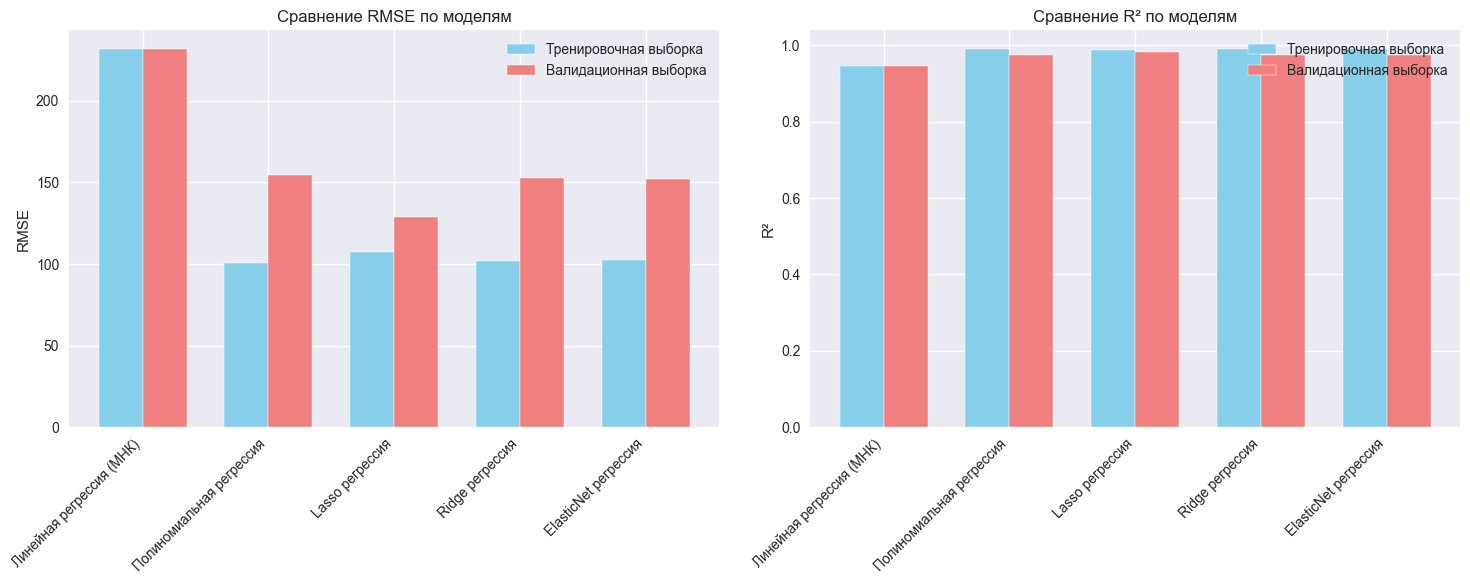


Расширенная сводная таблица:


,Модель,Гиперпараметры,Полиномиальные признаки,R² (тренировочная выборка),R² (валидационная выборка),RMSE (тренировочная выборка),RMSE (валидационная выборка),Разница RMSE (val-train),Переобучение (R² разница),Стабильность модели
0,Линейная регрессия (МНК),None,Нет,0.9452 ± 0.0000,0.9452 ± 0.0000,231.65 ± 0.00,231.65 ± 0.00,0.00,0.0000,Высокая
1,Полиномиальная регрессия,None,Да,0.9896 ± 0.0006,0.9748 ± 0.0072,100.74 ± -3.54,154.51 ± -21.48,53.77,0.0148,Высокая
2,Lasso регрессия,alpha = 5.455595,Да,0.9882 ± 0.0006,0.9827 ± 0.0043,107.39 ± -3.81,128.70 ± -19.67,21.31,0.0055,Высокая
3,Ridge регрессия,alpha = 0.885867,Да,0.9893 ± 0.0006,0.9756 ± 0.0057,102.16 ± -3.52,152.56 ± -20.32,50.40,0.0137,Высокая
4,ElasticNet регрессия,"alpha = 0.059948, l1_ratio = 0.9",Да,0.9893 ± 0.0006,0.9758 ± 0.0057,102.38 ± -3.50,151.84 ± -20.37,49.46,0.0135,Высокая



Детальный анализ моделей:

Линейная регрессия (МНК):
Гиперпараметры: Нет
RMSE (train/val): 231.65 ± 0.00 / 231.65 ± 0.00
R² (train/val): 0.9452 ± 0.0000 / 0.9452 ± 0.0000
Разница RMSE: 0.00
Переобучение (R²): 0.0000
Стабильность: Высокая
Рекомендации: Базовая модель для сравнения, недостаточно точная для практического применения

Полиномиальная регрессия:
Гиперпараметры: Нет
RMSE (train/val): 100.74 ± -3.54 / 154.51 ± -21.48
R² (train/val): 0.9896 ± 0.0006 / 0.9748 ± 0.0072
Разница RMSE: 53.77
Переобучение (R²): 0.0148
Стабильность: Высокая
Рекомендации: Хорошая точность, но есть риск переобучения. Требует регуляризации

Lasso регрессия:
Гиперпараметры: alpha = 5.455595
RMSE (train/val): 107.39 ± -3.81 / 128.70 ± -19.67
R² (train/val): 0.9882 ± 0.0006 / 0.9827 ± 0.0043
Разница RMSE: 21.31
Переобучение (R²): 0.0055
Стабильность: Высокая
Рекомендации: Оптимальна для отбора признаков и интерпретации результатов

Ridge регрессия:
Гиперпараметры: alpha = 0.885867
RMSE (train/val): 102.16 ±

In [101]:

# Создаем данные для визуализации
models = results_df['Модель']
rmse_train = [float(x.split('±')[0]) for x in results_df['RMSE (тренировочная выборка)']]
rmse_val = [float(x.split('±')[0]) for x in results_df['RMSE (валидационная выборка)']]
r2_train = [float(x.split('±')[0]) for x in results_df['R² (тренировочная выборка)']]
r2_val = [float(x.split('±')[0]) for x in results_df['R² (валидационная выборка)']]

# Настраиваем стиль
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# График RMSE
x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, rmse_train, width, label='Тренировочная выборка', color='skyblue')
ax1.bar(x + width/2, rmse_val, width, label='Валидационная выборка', color='lightcoral')
ax1.set_ylabel('RMSE')
ax1.set_title('Сравнение RMSE по моделям')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()

# График R²
ax2.bar(x - width/2, r2_train, width, label='Тренировочная выборка', color='skyblue')
ax2.bar(x + width/2, r2_val, width, label='Валидационная выборка', color='lightcoral')
ax2.set_ylabel('R²')
ax2.set_title('Сравнение R² по моделям')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.legend()

plt.tight_layout()
plt.show()

# Добавим дополнительные метрики в таблицу
results_df['Разница RMSE (val-train)'] = [
    f"{float(val.split('±')[0]) - float(train.split('±')[0]):.2f}"
    for train, val in zip(
        results_df['RMSE (тренировочная выборка)'],
        results_df['RMSE (валидационная выборка)']
    )
]

results_df['Переобучение (R² разница)'] = [
    f"{float(train.split('±')[0]) - float(val.split('±')[0]):.4f}"
    for train, val in zip(
        results_df['R² (тренировочная выборка)'],
        results_df['R² (валидационная выборка)']
    )
]

# Добавим оценку стабильности (по стандартному отклонению RMSE)
results_df['Стабильность модели'] = [
    'Высокая' if float(val.split('±')[1]) < 10 else 
    'Средняя' if float(val.split('±')[1]) < 15 else 
    'Низкая'
    for val in results_df['RMSE (валидационная выборка)']
]

print("\nРасширенная сводная таблица:")
display(results_df)

# Детальное сравнение моделей
print("\nДетальный анализ моделей:")
for model in models:
    model_data = results_df[results_df['Модель'] == model].iloc[0]
    print(f"\n{model}:")
    print(f"{'='*50}")
    print(f"Гиперпараметры: {model_data['Гиперпараметры'] if model_data['Гиперпараметры'] else 'Нет'}")
    print(f"RMSE (train/val): {model_data['RMSE (тренировочная выборка)']} / {model_data['RMSE (валидационная выборка)']}")
    print(f"R² (train/val): {model_data['R² (тренировочная выборка)']} / {model_data['R² (валидационная выборка)']}")
    print(f"Разница RMSE: {model_data['Разница RMSE (val-train)']}")
    print(f"Переобучение (R²): {model_data['Переобучение (R² разница)']}")
    print(f"Стабильность: {model_data['Стабильность модели']}")
    
    # Рекомендации по использованию
    if model == 'Линейная регрессия (МНК)':
        print("Рекомендации: Базовая модель для сравнения, недостаточно точная для практического применения")
    elif model == 'Полиномиальная регрессия':
        print("Рекомендации: Хорошая точность, но есть риск переобучения. Требует регуляризации")
    elif model == 'Lasso регрессия':
        print("Рекомендации: Оптимальна для отбора признаков и интерпретации результатов")
    elif model == 'Ridge регрессия':
        print("Рекомендации: Лучшая точность на тренировочных данных, хороша для предсказаний")
    elif model == 'ElasticNet регрессия':
        print("Рекомендации: Оптимальный баланс между точностью и интерпретируемостью")
